# AI - CA5
## Predicting Product Picture Categories using Neural Networks
### Soroosh Sadeghian - 810898048


In this assignment we use the pytorch library and construct different neural networks with different parameters to classify product images and analyze the effect of each parameter on the overall result.

In [1]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import time
from datetime import timedelta, datetime


Two different classes are implemented, both of which create a tensor object out of an image, while the second class also normalizes the images by dividing it by 255 as the image pixel values are between 0 and 255, and with dividing them all by 255, all of the values will be between 0 and 1.

In [2]:
class ToTensor(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        return torch.from_numpy(image)

class NormalizedToTensor(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255
        return torch.from_numpy(image)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp '/content/drive/My Drive/ai ca5/categorized_products.zip' ./

In [ ]:
!unzip './categorized_products.zip'

Two different transforms are implemented. Both convert the images to grayscale ones and create tensor objects from them. The only difference is that the second one also normalizes the images.
Afterwards, a dataset is loaded using each tensor. (The normalized dataset will be loaded later on.)

In [ ]:
transform = transforms.Compose(
    [
        transforms.Grayscale(),
        ToTensor() 
    ]
)

normal_transform = transforms.Compose(
    [
        transforms.Grayscale(),
        NormalizedToTensor() 
    ]
)
dataset = ImageFolder(
    './categorized_products',
    transform=transform
)

## Part 1.
In this part, images from 12 different classes should be chosen and shown.

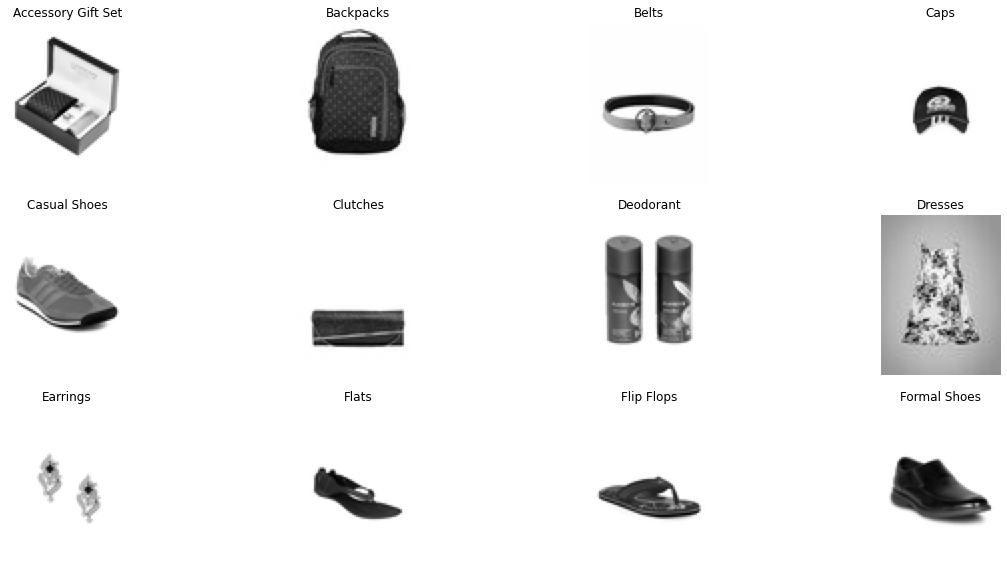

In [ ]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(3, 4, figsize=(20, 10)) 
    for i in range(3):
      for j in range(4):
        axs[i][j].color = 'red' 
        axs[i][j].imshow(img_array[i * 4 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 4 + j]])
        axs[i][j].axis('off')
    plt.show()

used_labels = []
used_images = []

counter = 0
while len(used_labels) < 12:
    image, label = dataset[counter]
    if label not in used_labels:
        used_labels.append(label)
        used_images.append(image)
        if len(used_labels) >= 12:
            break
    counter += 500
imshow(used_images, used_labels, dataset.classes)

## Part 2.

### Part 2.1.
The bar plot below shows the class distribution among the dataset. As it can be seen, the "Tshirts" class has the most data pieces and the "Kajal and Eyeliner" class has the least.

In [ ]:
def get_classes_count(dataset, classes):
    class_count = Counter()
    for _, label in dataset:
        class_count[classes[label]] += 1
    return class_count

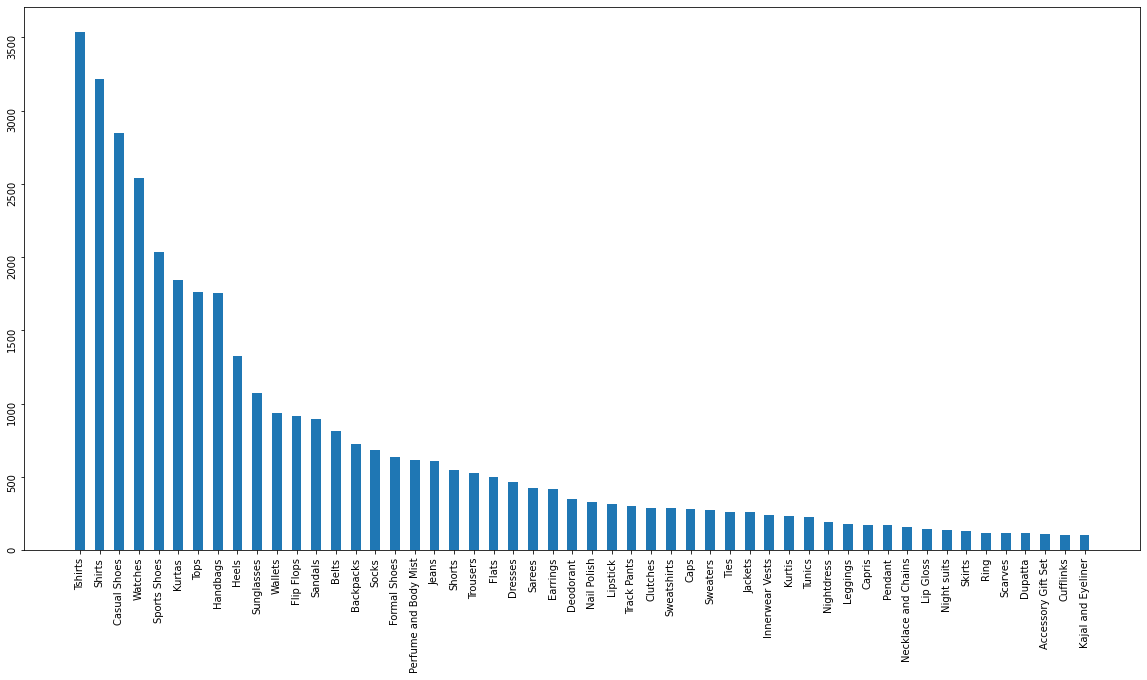

In [ ]:
class_count = get_classes_count(dataset, dataset.classes)
plot_data = [(cls, count) for cls, count in class_count.items()]
plot_data.sort(key=lambda x: x[1], reverse=True)
_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.bar([_[0] for _ in plot_data],[_[1] for _ in plot_data], width=0.5)
ax.tick_params(labelrotation=90)

### Part 2.2.
The data should be splitted into two parts, 20% of the data is reserved for testing purposes and the model won't see it's labels, while the other 80% of the data is used for training the model. In order to achieve this goal, the `train_test_split` function from the `scikit.learn` library is used and the stratify parameter is supplied to make sure that 20% of each class' data is separated for testing.

In [ ]:
indices = range(len(dataset)) # indices of the dataset
train_indices, test_indices, y_train, y_test = train_test_split(indices, dataset.targets, test_size=0.2, stratify=dataset.targets)

## Assumptions For the Next Parts



In the next parts of the problem, these assumptions are used, unless a change is stated in the explanations:


1.   Cross Entropy is used as the cost function.
2.   Stochastic Gradient Descent (SGD) is used as the optimizing method.
3.   Batch size is set to 64.
4.   Default epoch count is set to 10.
5.   Learning rate is set to 0.01.
6.   The relu function is used as each layer's activation function.
7.   The network's weight and bias values are initialized randomly.


In [ ]:
DEFAULT_BATCH_SIZE = 64
DEFAULT_LEARNING_RATE = 0.01
DEFAULT_LOSS_FUNCTION = nn.CrossEntropyLoss()

## Defining the network model, and the needed functions

The network model class takes a variable number of layer inputs and creates a network based on the layer inputs and the layer count.

In [3]:
class VariableLayerModel(nn.Module):
    def __init__(self, class_num, layer_inputs, act=F.relu):
        super(VariableLayerModel, self).__init__()

        self.layer_count = len(layer_inputs)
        for idx, inputs in enumerate(layer_inputs):
            setattr(self, f'layer{idx+1}', nn.Linear(*inputs))
            if idx < self.layer_count - 1:
                setattr(self, f'act{idx+1}', act)

    def forward(self, x):

        x = x.view(x.size(0), -1)
        for i in range(self.layer_count):
            layer_func = getattr(self, f'layer{i+1}')
            x = layer_func(x)
            if i < self.layer_count - 1:
                activation_func = getattr(self, f'act{i+1}')
                x = activation_func(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):

  total_time = 0.

  plotting = [[], []]
  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

      average_loss = train_loss / len(train_loader)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
      plotting[0].append(epoch + 1)
      plotting[1].append(average_loss)
  _, ax = plt.subplots(1, 1, figsize=(20, 10))
  ax.bar(plotting[0],plotting[1],width=0.5)
  ax.set_xlabel( "avg_loss",labelpad=15, size=20)
  print('total training time: %.3f minutes' % (total_time / 60))

In [ ]:
def test_model_accuracy(model, data_loader, classes):

    total_items_in_class = [0 for i in range(len(classes))]
    correct_predictions = [0 for i in range(len(classes))]
    # Iterate through test datasethtml/
    with torch.no_grad():
      for images, labels in data_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)

        predicted = predicted.to('cpu')
        for i in range(labels.size(0)):
          total_items_in_class[labels[i]] += 1 
          if predicted[i] == labels[i] :
            correct_predictions[labels[i]] += 1 

    accuracy = 100 * sum(correct_predictions) / sum(total_items_in_class)
    print('Accuracy: {}%'.format(accuracy))
    return total_items_in_class, correct_predictions, accuracy

Different model configs (both layer count and layer inputs) have been declared below. All of them have been tested earlier but as the results are the same for each network (as the data have not been normalized yet) only two of the networks will be trained and the results will be printed below. In the next part (Part 4) all of the networks will be tested and the optimized one will be selected for the rest of the problem. 

In [4]:
FEATURE_SIZE = 60 * 80
CLASSES_NUM = 52
four_layer_network_inputs = [
    [
        [FEATURE_SIZE, 7500],
        [7500, 500],
        [500, 60],
        [60, CLASSES_NUM],
    ],
    [
        [FEATURE_SIZE, 10000],
        [10000, 1000],
        [1000, 100],
        [100, CLASSES_NUM],
    ],
]

five_layer_network_inputs = [
    [    
        [FEATURE_SIZE, 10000],
        [10000, 3000],
        [3000, 500],
        [500, 100],
        [100, CLASSES_NUM],
    ],
]


def get_optimized_network(inputs, train_loader, test_loader, dataset):
    best_layer_accuracy = {lc: {key: {'accuracy': 0, 'set_index': None, 'total_count': 0, 'correct_predictions': 0} for key in ['test', 'train']} for lc in inputs}
    for layer_count, layer_inputs_set in inputs.items():
        for index, layer_inputs in enumerate(layer_inputs_set):
            print(f'Training network with {layer_count} layers and {layer_inputs} parameters.')
            model = VariableLayerModel(len(dataset.classes), layer_inputs)
            model = model.to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=DEFAULT_LEARNING_RATE)
            fit(model, train_loader, device, DEFAULT_LOSS_FUNCTION, optimizer)
            test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(model, test_loader, dataset.classes)
            train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(model, train_loader, dataset.classes)
            if test_accuracy > best_layer_accuracy[layer_count]['test']['accuracy']:
                best_layer_accuracy[layer_count]['test']['accuracy'] = test_accuracy
                best_layer_accuracy[layer_count]['test']['set_index'] = index
                best_layer_accuracy[layer_count]['test']['total_count'] = test_total_count
                best_layer_accuracy[layer_count]['test']['correct_predictions'] = test_correct_predictions
            if train_accuracy > best_layer_accuracy[layer_count]['train']['accuracy']:
                best_layer_accuracy[layer_count]['train']['accuracy'] = train_accuracy
                best_layer_accuracy[layer_count]['train']['set_index'] = index
                best_layer_accuracy[layer_count]['train']['total_count'] = train_total_count
                best_layer_accuracy[layer_count]['train']['correct_predictions'] = train_correct_predictions
    for layer_count, result in best_layer_accuracy.items():
        print(f'{layer_count} Layer Network Summary:')
        print(f'Best Test Accuracy: {result["test"]["accuracy"]}')
        print(f'This result was achieved using these parameters: {inputs[layer_count][result["test"]["set_index"]]}')
        print(f'Best Train Accuracy: {result["train"]["accuracy"]}')
        print(f'This result was achieved using these parameters: {inputs[layer_count][result["train"]["set_index"]]}')

    best_accuracy_layer_count, best_accuracy_data = max(best_layer_accuracy.items(), key=lambda x: x[1]["test"]["accuracy"])
    return best_accuracy_layer_count, best_accuracy_data

In [ ]:
def plot_class_recalls(total_test_count, correct_test_predictions, total_train_count, correct_train_predictions, classes, title=None):
    accuracy_per_class = {
        'test': [correct_test_predictions[i] / total_test_count[i] for i in range(len(total_test_count))],
        'train': [correct_train_predictions[i] / total_train_count[i] for i in range(len(total_train_count))]
    }

    x_axis_points = np.arange(len(classes))

    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.bar(x_axis_points + 0.00, accuracy_per_class['test'], color = 'r', width = 0.25)
    ax.bar(x_axis_points + 0.5, accuracy_per_class['train'], color = 'b', width = 0.25)
    plt.xticks(x_axis_points + 0.25, classes)
    ax.tick_params(labelrotation=90)
    ax.set_xlabel("Classes", labelpad=15, size=20)
    ax.set_ylabel("Recall", labelpad=15, size=20)
    plt.legend(["Test", "Train"])
    if title:
        ax.set_title(title)

## Part 3.

Different neural networks should be trained on the data and analyzed to find the optimized number of layers and neurons.

### Part 3.1.

In [10]:
sample_layer_inputs = [
    [FEATURE_SIZE, 10000],
    [10000, 1000],
    [1000, 100],
    [100, CLASSES_NUM],
]
sample_model = VariableLayerModel(CLASSES_NUM, sample_layer_inputs)
params = list(sample_model.parameters())
for i, param in enumerate(params):
    param_name = 'weights' if not i%2 else 'bias'
    print(f'Layer {(i//2) + 1} {param_name}:')
    print(param.shape)

Layer 1 weights:
torch.Size([10000, 4800])
Layer 1 bias:
torch.Size([10000])
Layer 2 weights:
torch.Size([1000, 10000])
Layer 2 bias:
torch.Size([1000])
Layer 3 weights:
torch.Size([100, 1000])
Layer 3 bias:
torch.Size([100])
Layer 4 weights:
torch.Size([52, 100])
Layer 4 bias:
torch.Size([52])


Each layer has got an input count (which is the second number of the weights list) and an output count (which is the first one in the weights list) and a bias count, which is stated below the weights list.

### Part 3.2.

The test and train samplers are defined as random samplers and the loaders are implemented with the default batch size.

In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=DEFAULT_BATCH_SIZE, sampler=train_sampler, num_workers=16)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=DEFAULT_BATCH_SIZE, sampler=test_sampler, num_workers=16)

Training network with 4 layers and [[4800, 7500], [7500, 500], [500, 60], [60, 52]] parameters.
epoch 1, train_loss: nan, time elapsed: 14.699235 seconds
epoch 2, train_loss: nan, time elapsed: 14.529641 seconds
epoch 3, train_loss: nan, time elapsed: 14.510279 seconds
epoch 4, train_loss: nan, time elapsed: 14.523703 seconds
epoch 5, train_loss: nan, time elapsed: 14.481618 seconds
epoch 6, train_loss: nan, time elapsed: 14.487258 seconds
epoch 7, train_loss: nan, time elapsed: 14.384256 seconds
epoch 8, train_loss: nan, time elapsed: 14.518546 seconds
epoch 9, train_loss: nan, time elapsed: 14.314367 seconds
epoch 10, train_loss: nan, time elapsed: 14.341301 seconds
total training time: 2.413 minutes
Accuracy: 0.2953020134228188%
Accuracy: 0.29866774052820566%
Training network with 4 layers and [[4800, 10000], [10000, 1000], [1000, 100], [100, 52]] parameters.
epoch 1, train_loss: nan, time elapsed: 15.866232 seconds
epoch 2, train_loss: nan, time elapsed: 15.760046 seconds
epoch 3, 

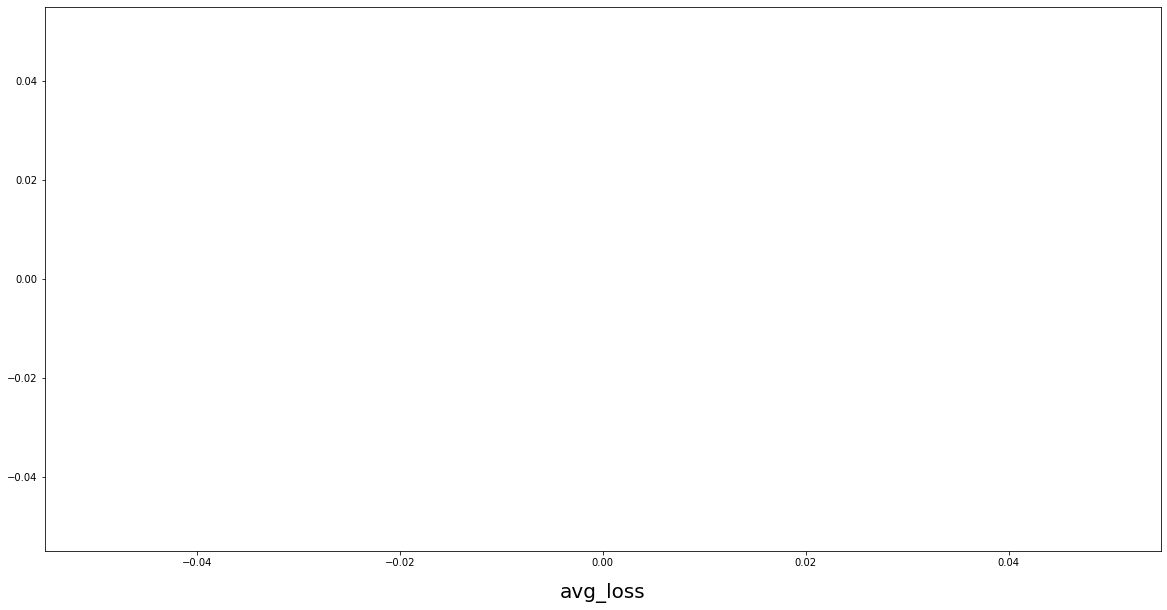

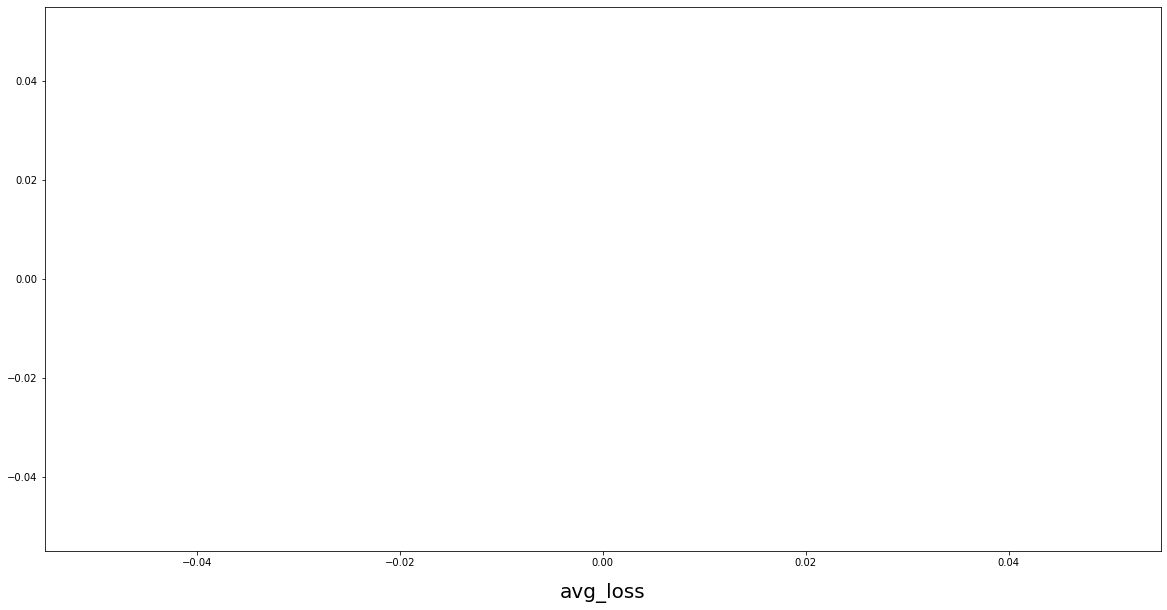

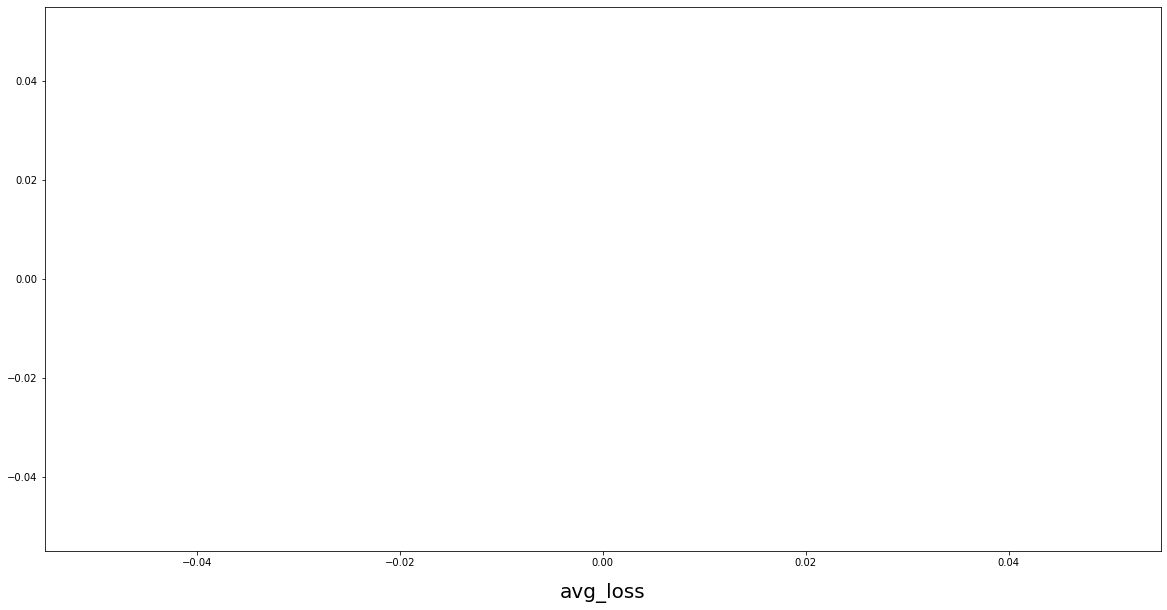

In [ ]:
part_3_network_inputs = {
    4: four_layer_network_inputs,
    5: five_layer_network_inputs,
}

part_3_best_network_layer_count, part_3_best_network_data = get_optimized_network(part_3_network_inputs, train_loader, test_loader, dataset)

As seen in the results above, the train loss value is equal to "nan". The data given to this model is not normalized and the image sizes are too big, which results in the training loss becoming too large and overflowing.

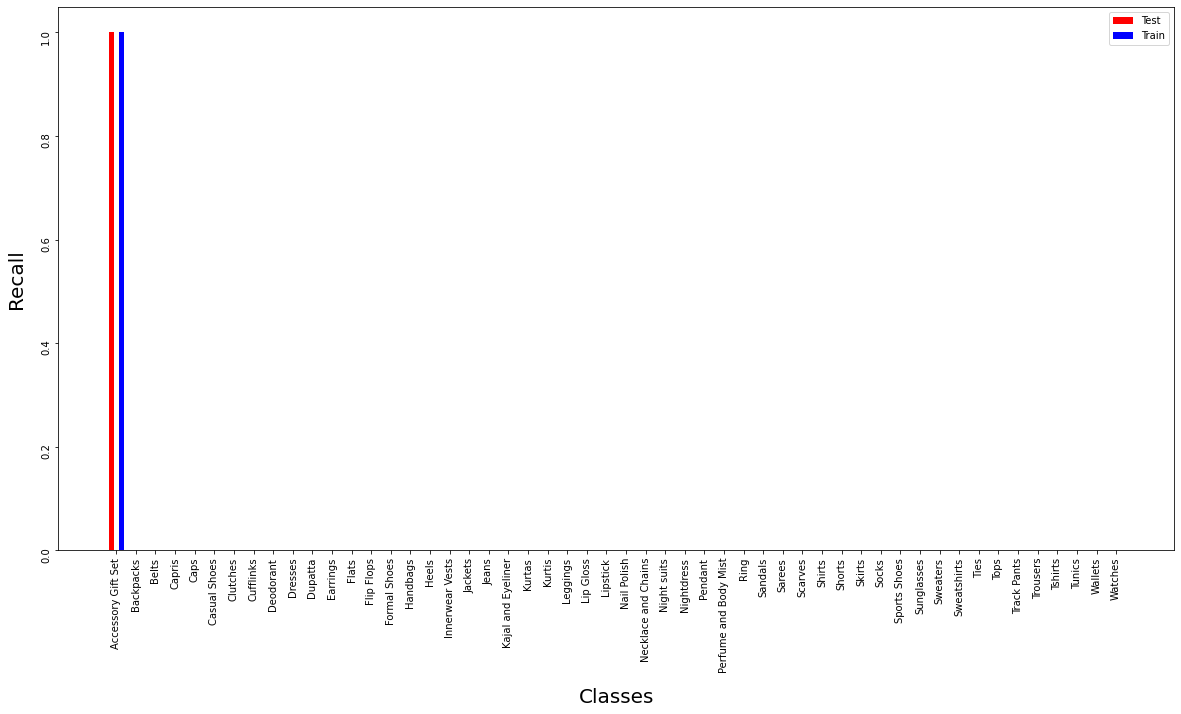

In [ ]:
plot_class_recalls(
    part_3_best_network_data['test']['total_count'], 
    part_3_best_network_data['test']['correct_predictions'], 
    part_3_best_network_data['train']['total_count'], 
    part_3_best_network_data['train']['correct_predictions'],
    dataset.classes,
)

 According to this plot, the model isn't trained at all as it returns the first class for each data and the first class' recall will be equal to 1 while every other class' recall value will be zero. This will be fixed in the next parts where the data are normalized.


## Part 4.
The data will be normalized from now on. We shall see it's effects on the neural networks soon. 9 different networks will be trained and the best one will be chosen to work with thereafter.

In [ ]:
normalized_dataset = ImageFolder(
    './categorized_products',
    transform=normal_transform
)

normalized_indices = range(len(normalized_dataset)) # indices of the dataset
normalized_train_indices, normalized_test_indices, y_train, y_test = train_test_split(normalized_indices, normalized_dataset.targets, test_size=0.2, stratify=normalized_dataset.targets)

normalized_train_sampler = SubsetRandomSampler(normalized_train_indices)
normalized_test_sampler = SubsetRandomSampler(normalized_test_indices)

normalized_train_loader = torch.utils.data.DataLoader(normalized_dataset, batch_size=DEFAULT_BATCH_SIZE, sampler=normalized_train_sampler, num_workers=16)
normalized_test_loader = torch.utils.data.DataLoader(normalized_dataset, batch_size=DEFAULT_BATCH_SIZE, sampler=normalized_test_sampler, num_workers=16)



Training network with 4 layers and [[4800, 7500], [7500, 500], [500, 60], [60, 52]] parameters.
epoch 1, train_loss: 3.274, time elapsed: 14.839368 seconds
epoch 2, train_loss: 2.458, time elapsed: 14.680833 seconds
epoch 3, train_loss: 2.021, time elapsed: 14.616575 seconds
epoch 4, train_loss: 1.803, time elapsed: 14.570938 seconds
epoch 5, train_loss: 1.657, time elapsed: 14.715713 seconds
epoch 6, train_loss: 1.555, time elapsed: 14.574699 seconds
epoch 7, train_loss: 1.458, time elapsed: 14.672903 seconds
epoch 8, train_loss: 1.388, time elapsed: 14.606541 seconds
epoch 9, train_loss: 1.323, time elapsed: 14.63164 seconds
epoch 10, train_loss: 1.280, time elapsed: 14.682694 seconds
total training time: 2.443 minutes
Accuracy: 54.75167785234899%
Accuracy: 55.64951844021611%
Training network with 4 layers and [[4800, 10000], [10000, 1000], [1000, 100], [100, 52]] parameters.
epoch 1, train_loss: 3.165, time elapsed: 16.041327 seconds
epoch 2, train_loss: 2.310, time elapsed: 16.0179

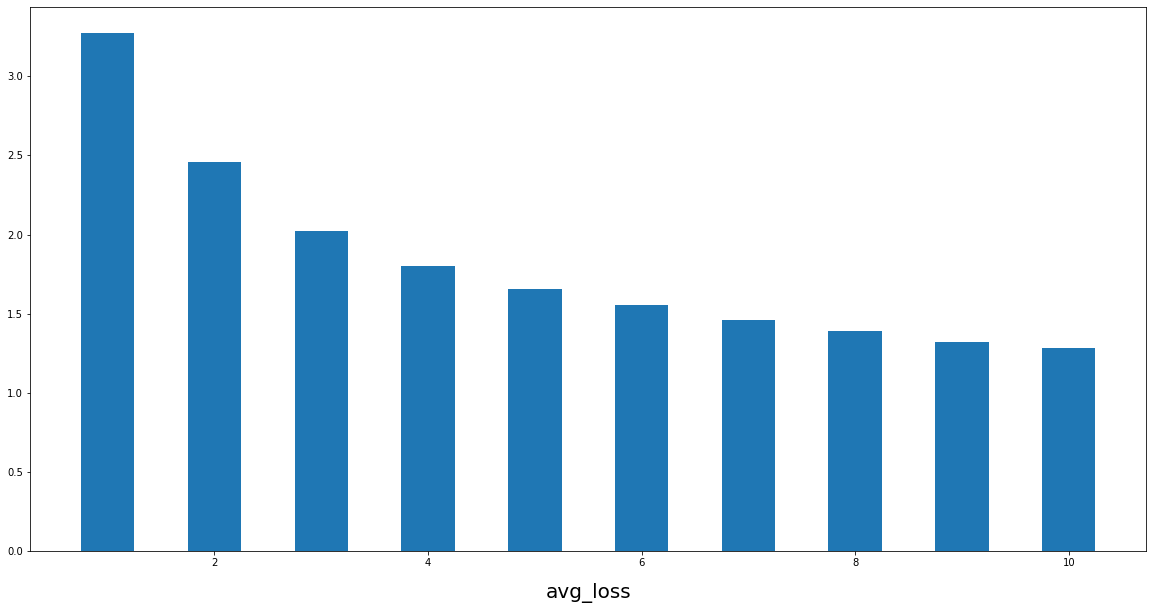

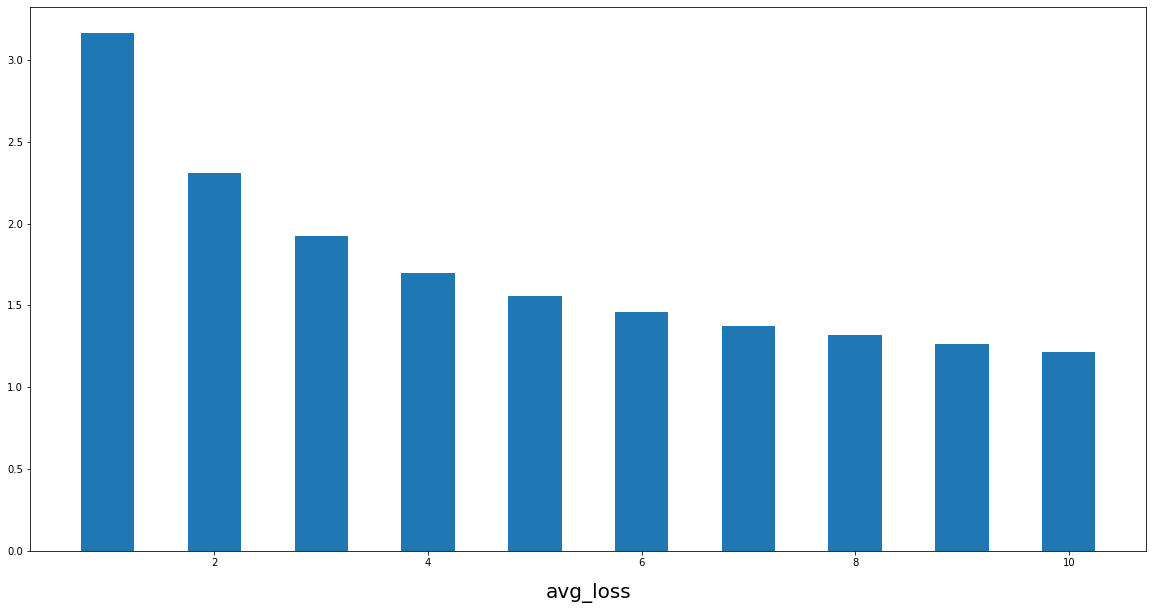

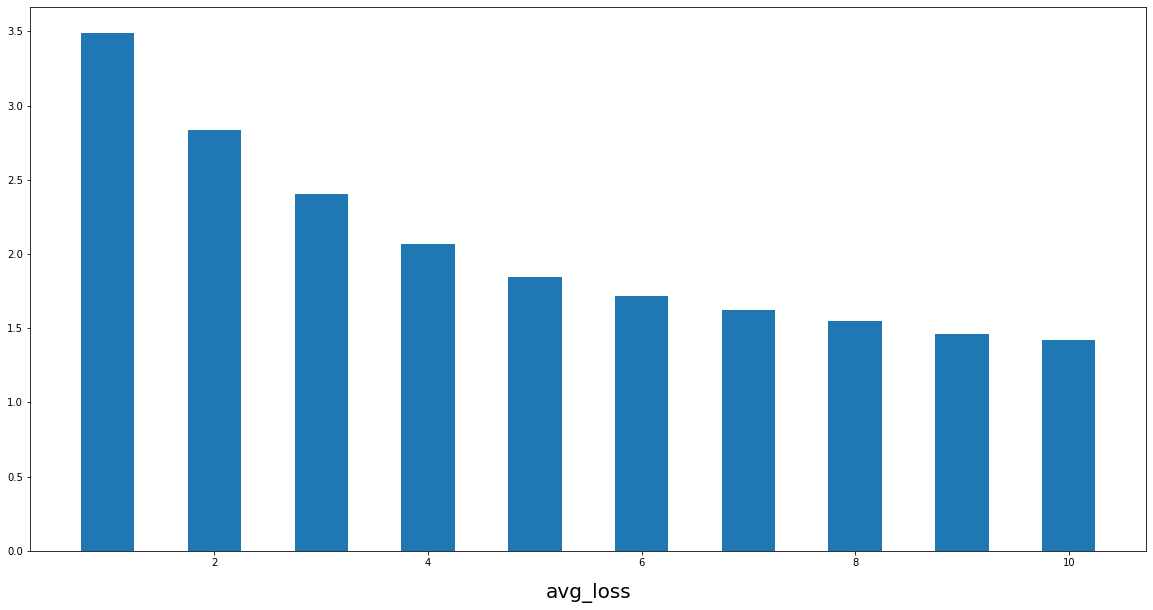

In [ ]:
network_layer_inputs = {
    4: four_layer_network_inputs,
    5: five_layer_network_inputs,
}

best_network_layer_count, best_network_data = get_optimized_network(network_layer_inputs, normalized_train_loader, normalized_test_loader, normalized_dataset)

In [ ]:
optimized_layer_inputs = network_layer_inputs[best_network_layer_count][best_network_data['test']['set_index']]
print(f'Optimized layer count: {best_network_layer_count}')
print(f'Optimized parameter set: {optimized_layer_inputs}')
print(f'Network Accuracy: {best_network_data["test"]["accuracy"]}')

Optimized layer count: 4
Optimized parameter set: [[4800, 10000], [10000, 1000], [1000, 100], [100, 52]]
Network Accuracy: 58.40268456375839


As seen, the network with the layer count and parameter set stated above had the best accuracy among the tested networks:
CUDA faced a lack of memory while training some 6 layer networks and the 6 layer networks also had a very long training time and low accuracy, so the final decision is to use the network stated above.

When compared to the results in part 3, it can be seen that there has been a significant rise in the accuracy values (rising from ~29% to ~52%) and the average loss values now have numerical values which are all results of the data being normalized. The chosen network will be trained again and the per-class recall plot will be drawn below.
And also as seen above, the loss decreases as the epochs advance.


epoch 1, train_loss: 3.181, time elapsed: 16.189491 seconds
epoch 2, train_loss: 2.360, time elapsed: 15.880748 seconds
epoch 3, train_loss: 1.931, time elapsed: 16.081481 seconds
epoch 4, train_loss: 1.667, time elapsed: 15.947592 seconds
epoch 5, train_loss: 1.523, time elapsed: 16.052245 seconds
epoch 6, train_loss: 1.424, time elapsed: 15.884436 seconds
epoch 7, train_loss: 1.336, time elapsed: 15.950811 seconds
epoch 8, train_loss: 1.283, time elapsed: 16.042871 seconds
epoch 9, train_loss: 1.239, time elapsed: 15.936654 seconds
epoch 10, train_loss: 1.201, time elapsed: 16.036437 seconds
total training time: 2.667 minutes
Test Accuracy:
Accuracy: 62.13422818791946%
Train Accuracy:
Accuracy: 62.51552065505554%


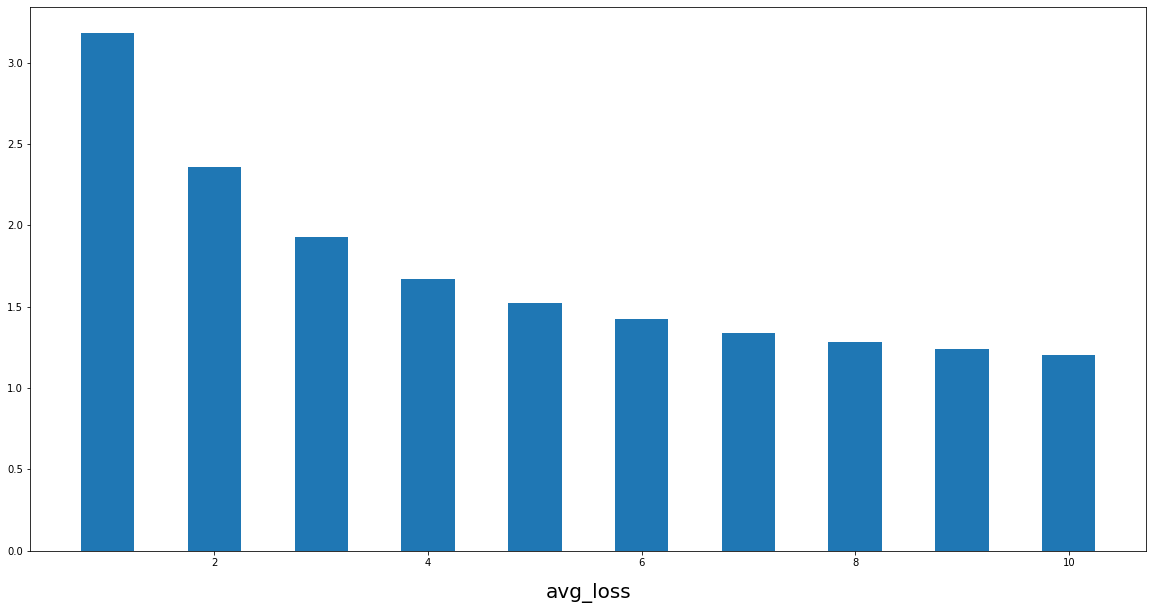

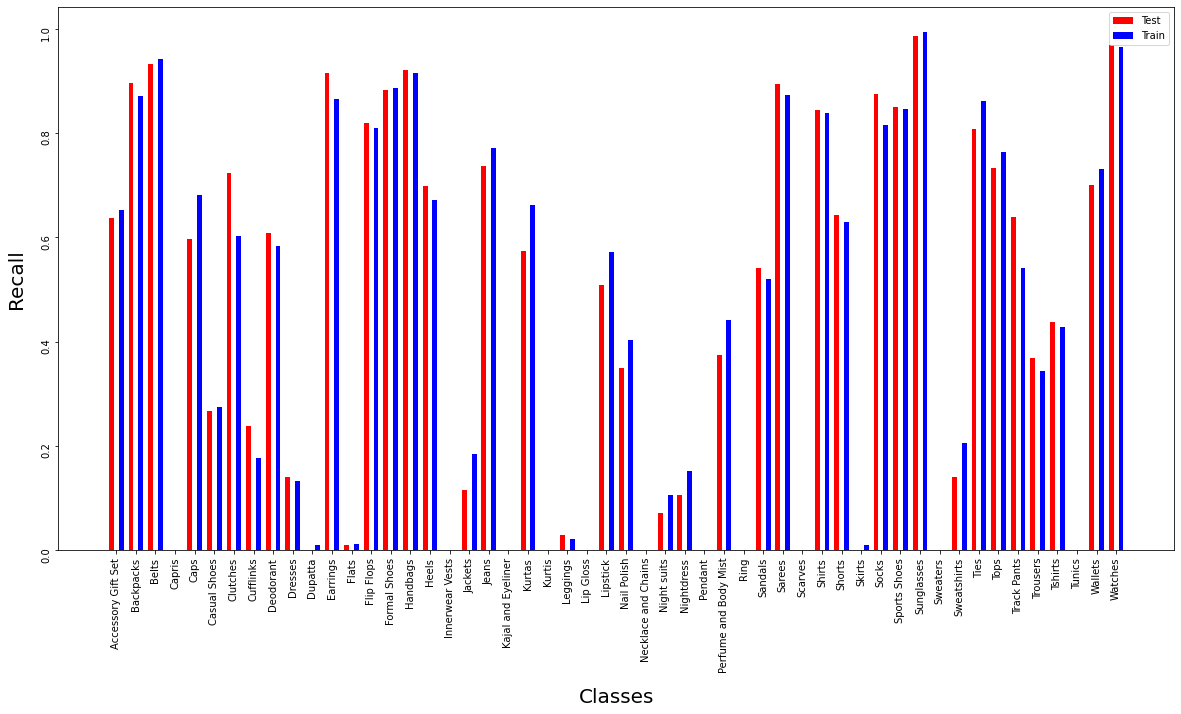

In [ ]:
def get_part_4_results(dataset, layer_inputs, train_loader, test_loader, criterion=DEFAULT_LOSS_FUNCTION, learning_rate=DEFAULT_LEARNING_RATE):
    optimized_network = VariableLayerModel(dataset.classes, layer_inputs)
    optimized_network = optimized_network.to(device)
    optimizer = torch.optim.SGD(optimized_network.parameters(), lr=learning_rate)
    fit(optimized_network, train_loader, device, criterion, optimizer)
    print('Test Accuracy:')
    test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network, test_loader, dataset.classes)
    print('Train Accuracy:')
    train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network, train_loader, dataset.classes)
    plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes)

get_part_4_results(normalized_dataset, optimized_layer_inputs, normalized_train_loader, normalized_test_loader)

## Part 5.
In this part, the effect of the weight parameter will be analyzed.

### Part 5.1.
In this part the effects of setting the weights to zero is analyzed.

epoch 1, train_loss: 3.896, time elapsed: 16.195115 seconds
epoch 2, train_loss: 3.798, time elapsed: 15.982419 seconds
epoch 3, train_loss: 3.720, time elapsed: 15.984317 seconds
epoch 4, train_loss: 3.661, time elapsed: 16.048677 seconds
epoch 5, train_loss: 3.616, time elapsed: 16.023139 seconds
epoch 6, train_loss: 3.582, time elapsed: 15.961929 seconds
epoch 7, train_loss: 3.557, time elapsed: 16.059055 seconds
epoch 8, train_loss: 3.538, time elapsed: 16.122718 seconds
epoch 9, train_loss: 3.524, time elapsed: 15.900452 seconds
epoch 10, train_loss: 3.513, time elapsed: 15.868188 seconds
total training time: 2.669 minutes
Test Accuracy:
Accuracy: 9.48993288590604%
Train Accuracy:
Accuracy: 9.48689553340716%


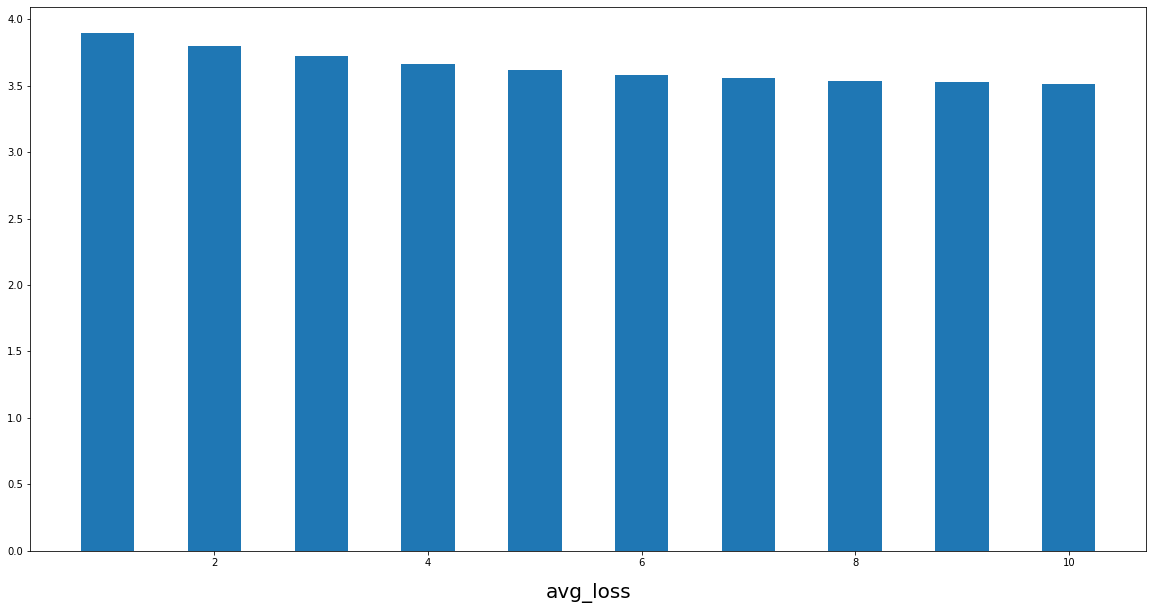

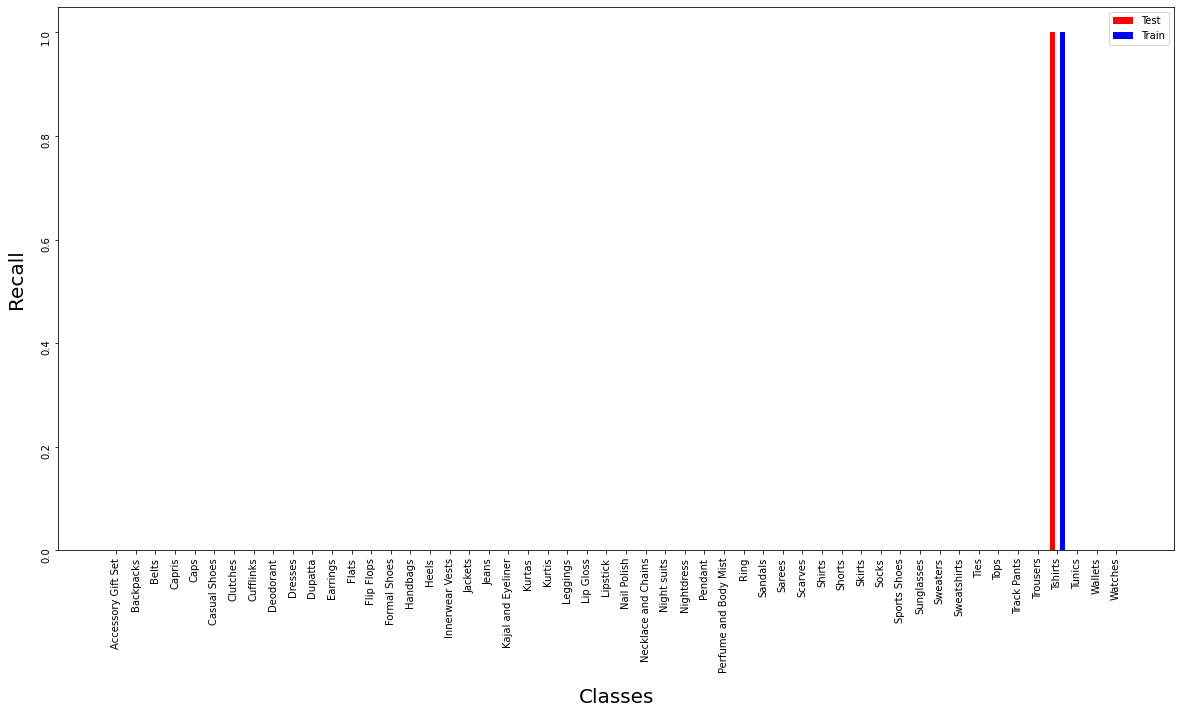

In [ ]:
def get_part_5_results(dataset, layer_inputs, train_loader, test_loader, learning_rate, loss_function):

    def set_weights_to_zero(x):
        if type(x) == nn.Linear:
            x.weight.data.fill_(0)
            x.bias.data.fill_(0)

    optimized_network_with_zero_weights = VariableLayerModel(dataset.classes, layer_inputs)
    optimized_network_with_zero_weights = optimized_network_with_zero_weights.apply(set_weights_to_zero)

    optimized_network_with_zero_weights = optimized_network_with_zero_weights.to(device)
    optimizer = torch.optim.SGD(optimized_network_with_zero_weights.parameters(), lr=learning_rate)
    fit(optimized_network_with_zero_weights, train_loader, device, loss_function, optimizer)
    print('Test Accuracy:')
    test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network_with_zero_weights, test_loader, dataset.classes)
    print('Train Accuracy:')
    train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network_with_zero_weights, train_loader, dataset.classes)
    plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes)


get_part_5_results(normalized_dataset, optimized_layer_inputs, normalized_train_loader, normalized_test_loader, DEFAULT_LEARNING_RATE, DEFAULT_LOSS_FUNCTION)

As seen in the results, if all of the weight and bias values are equal to zero, none of the node parameters will be updated except for the bias value of the last layer, which is dependent on the number of samples it faces from each class. So it will always return the class with the highest number of samples as the final prediction.

### Part 5.2.
Using random weights is usually a good idea as it's unbiased and prevents getting stuck at a local minimum. However this may result in a number of problems such as Vanishing or Exploding gradients. In the vanishing gradients problem, the gradients are so small that they prevent the weight from being effectively updated and thus the learning process won't advance as desired. On the other side, if the gradients are too large, they cause very big updates which makes the network unstable resulting in the network returning poor predictions or even nothing useful at all.

## Part 6.
The effects of the learning rate value will be analyzed in this part.

### Part 6.1.
Different learning rates are to be tested and the optimized learning rate will be used from now on.

Training network with learning rate: 0.001
epoch 1, train_loss: 3.728, time elapsed: 16.108834 seconds
epoch 2, train_loss: 3.465, time elapsed: 16.034559 seconds
epoch 3, train_loss: 3.378, time elapsed: 15.996726 seconds
epoch 4, train_loss: 3.288, time elapsed: 15.956435 seconds
epoch 5, train_loss: 3.159, time elapsed: 16.032361 seconds
epoch 6, train_loss: 3.014, time elapsed: 16.02354 seconds
epoch 7, train_loss: 2.885, time elapsed: 16.094983 seconds
epoch 8, train_loss: 2.778, time elapsed: 15.959896 seconds
epoch 9, train_loss: 2.682, time elapsed: 16.079772 seconds
epoch 10, train_loss: 2.589, time elapsed: 16.053454 seconds
total training time: 2.672 minutes
Test Accuracy:
Accuracy: 31.033557046979865%
Train Accuracy
Accuracy: 30.745998187858653%
Training network with learning rate: 0.005
epoch 1, train_loss: 3.431, time elapsed: 15.77687 seconds
epoch 2, train_loss: 2.825, time elapsed: 16.129444 seconds
epoch 3, train_loss: 2.402, time elapsed: 15.919157 seconds
epoch 4, t

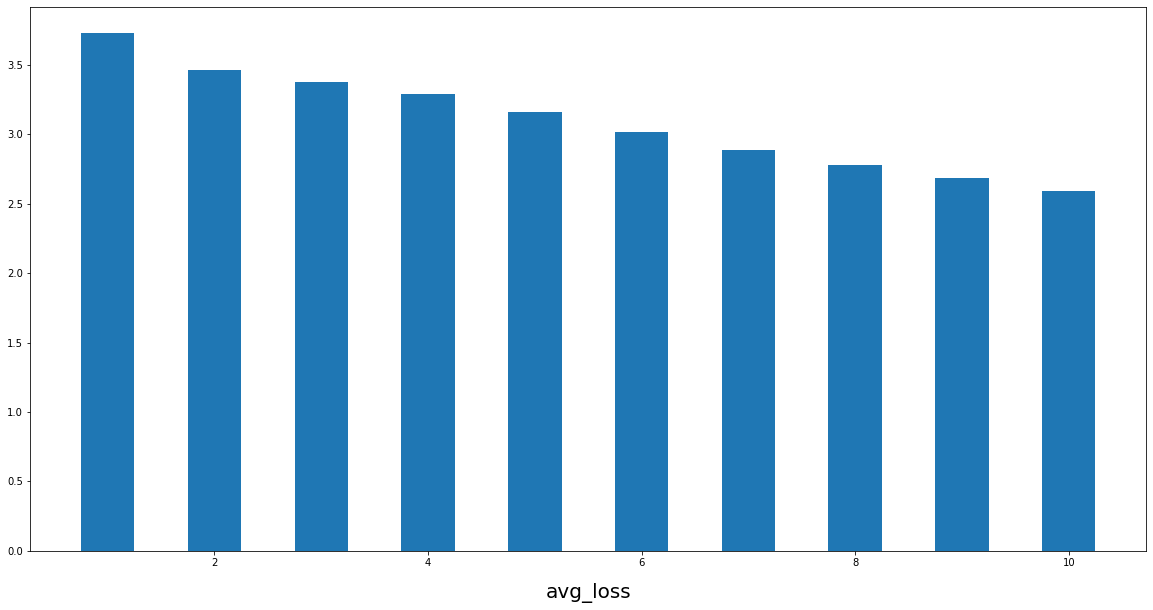

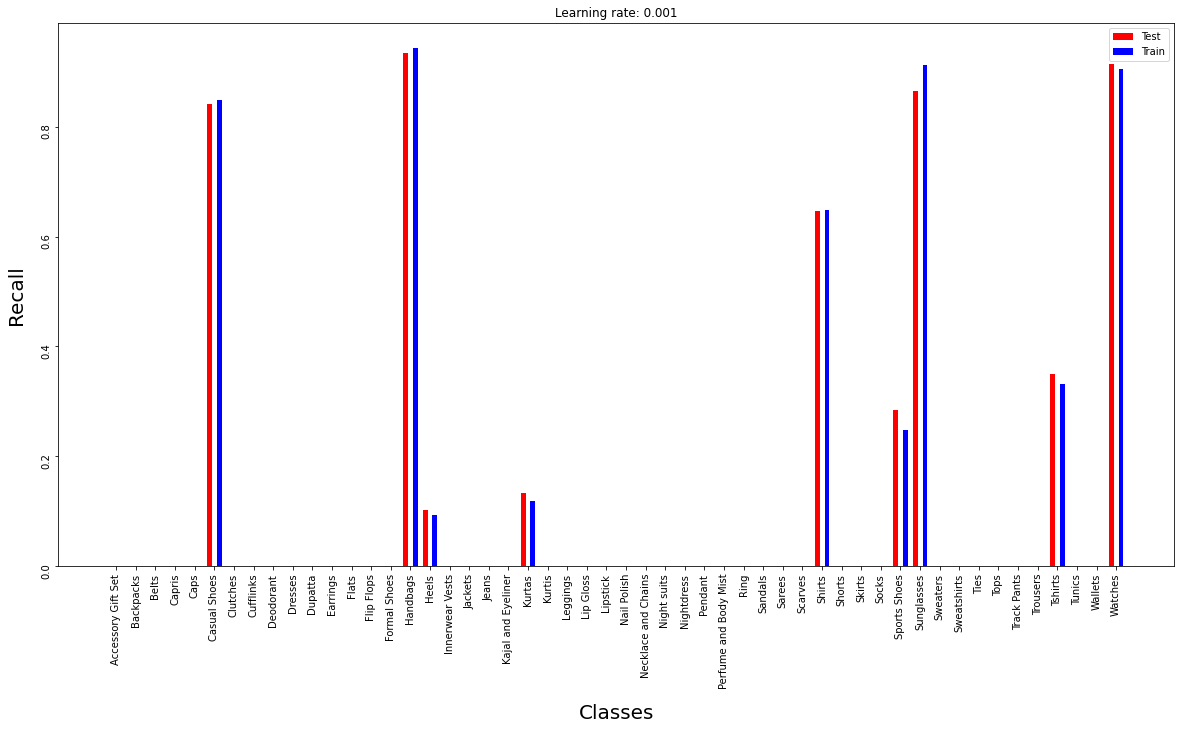

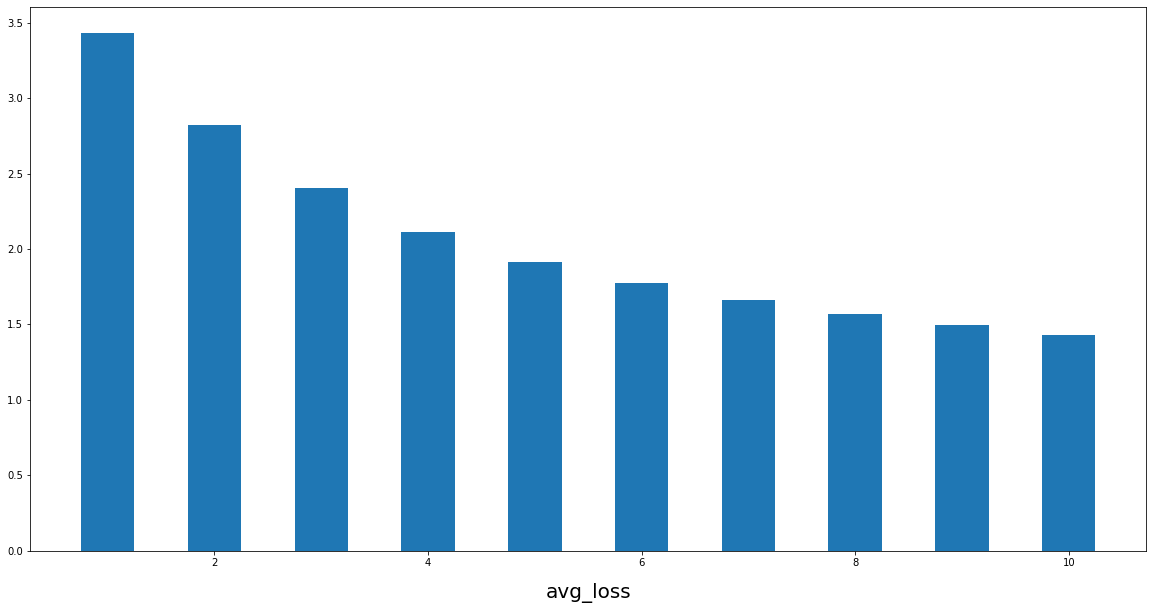

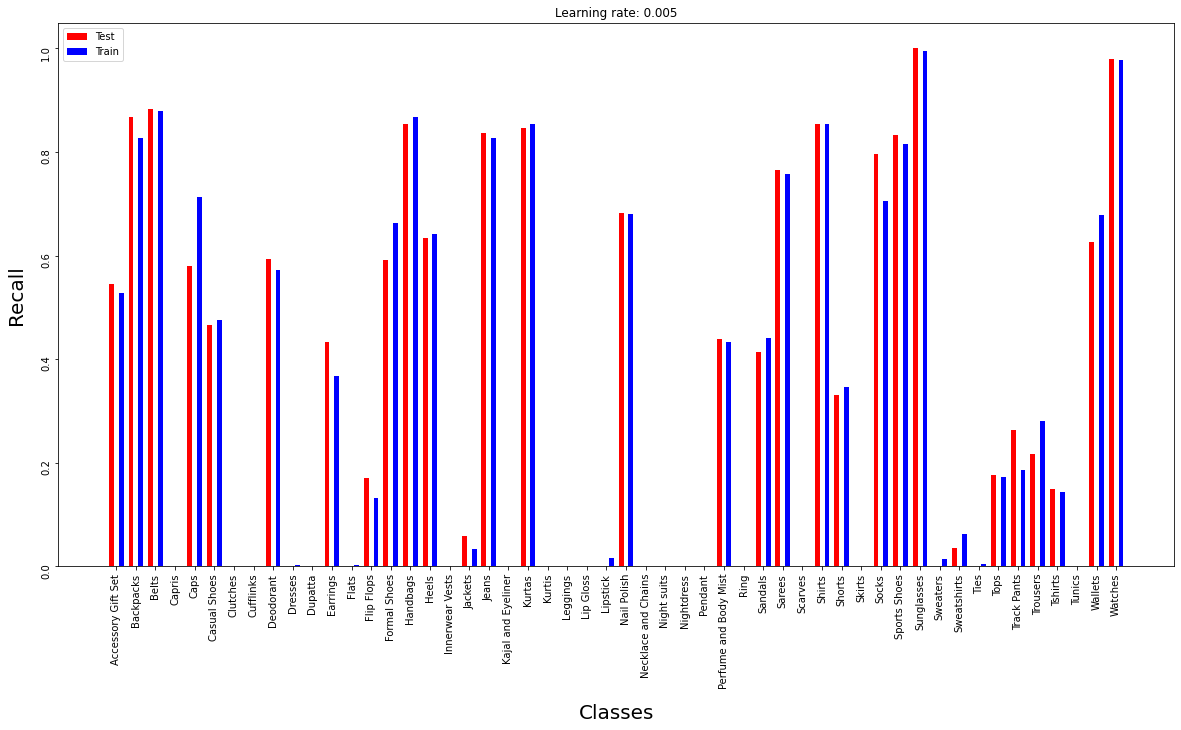

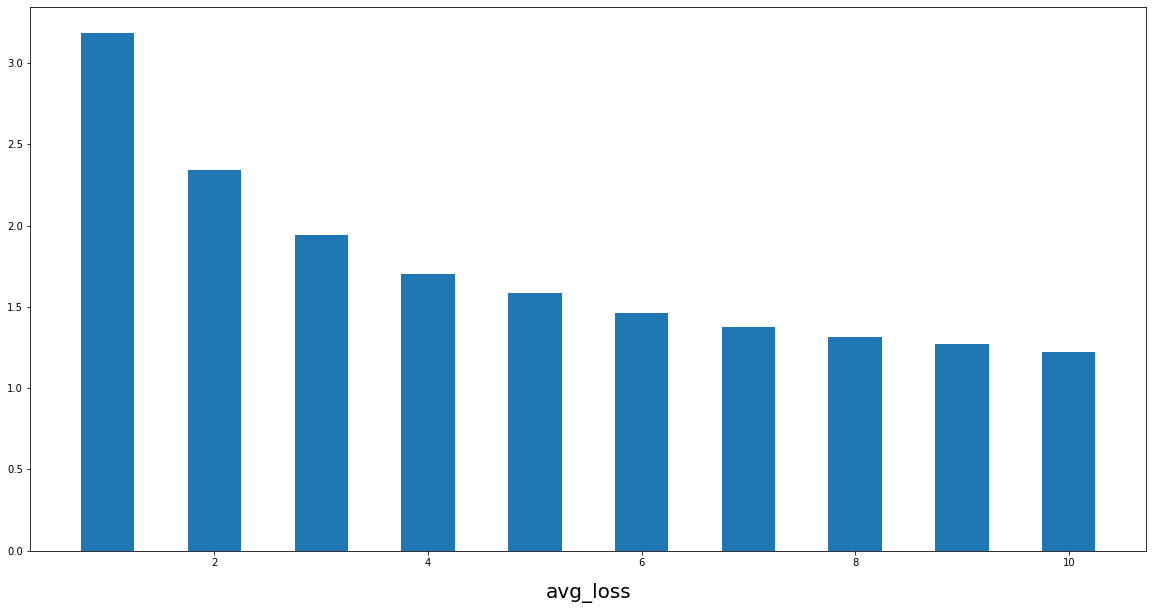

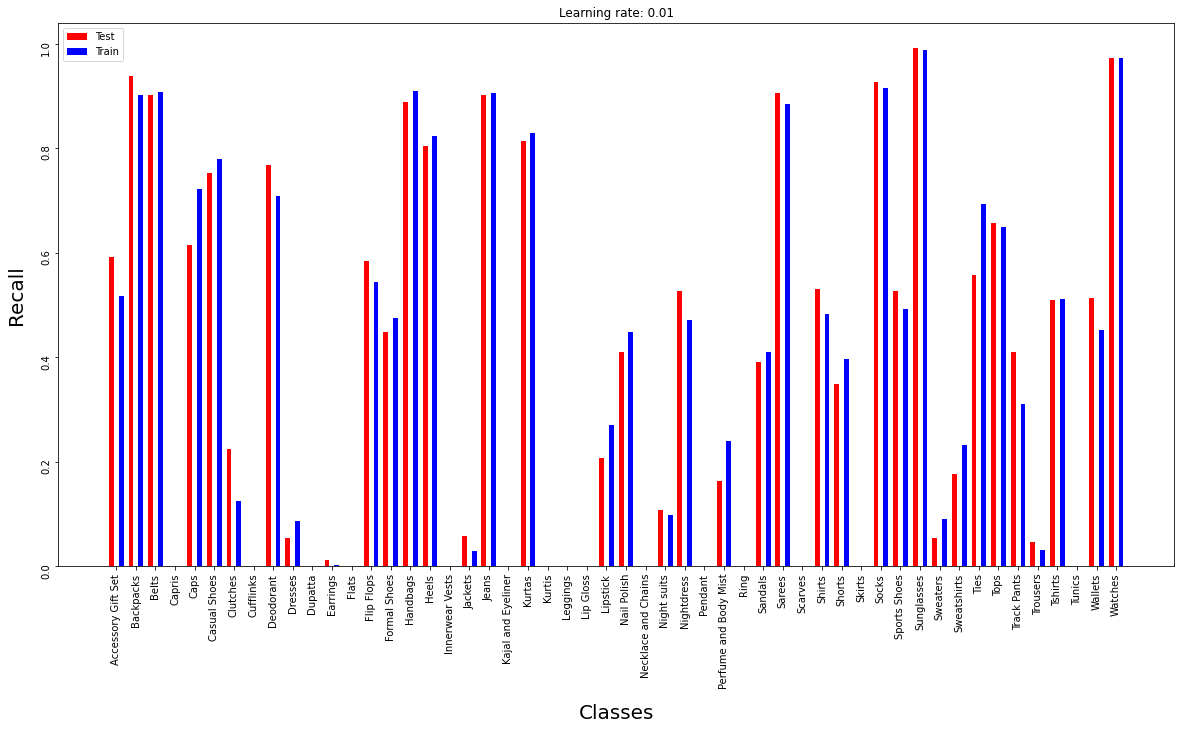

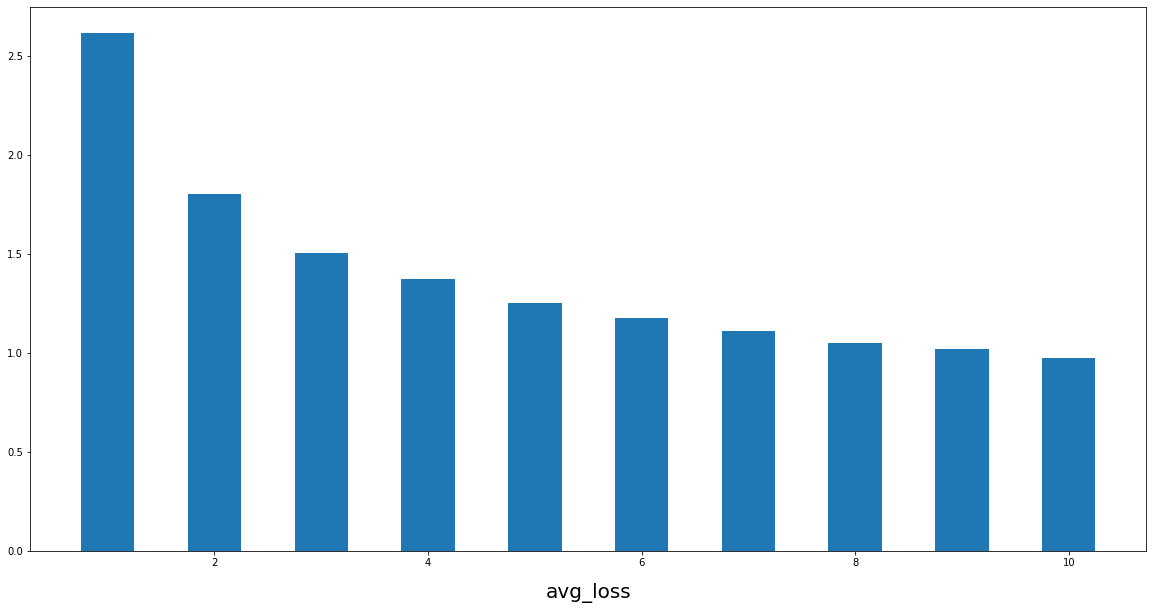

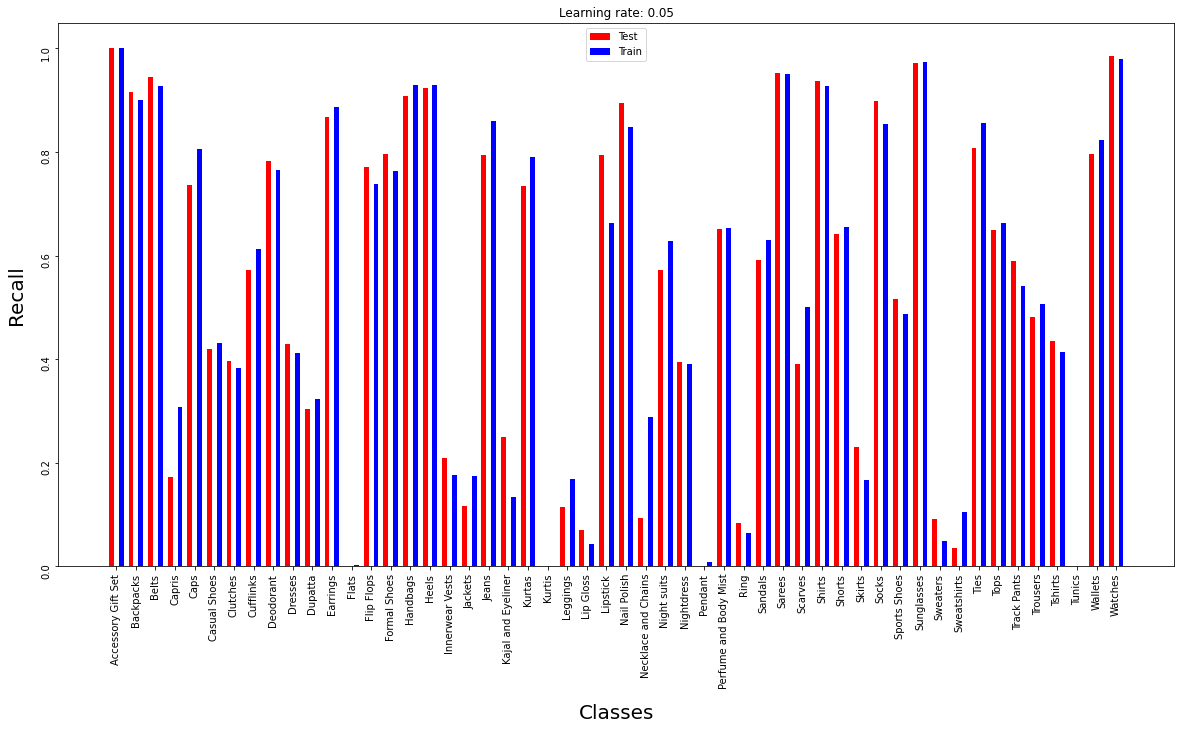

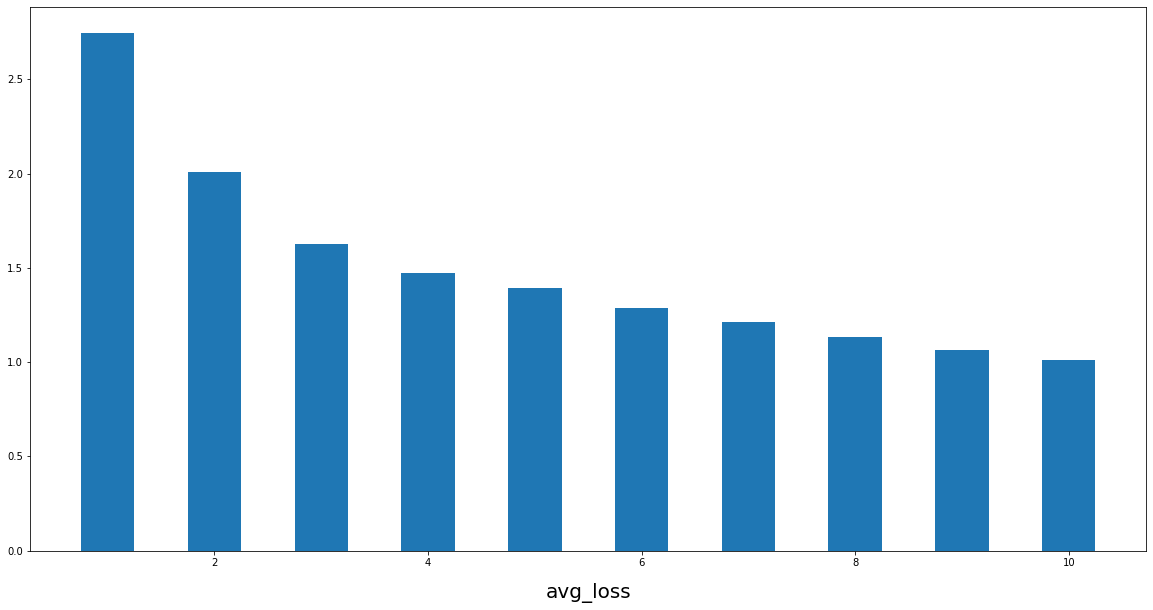

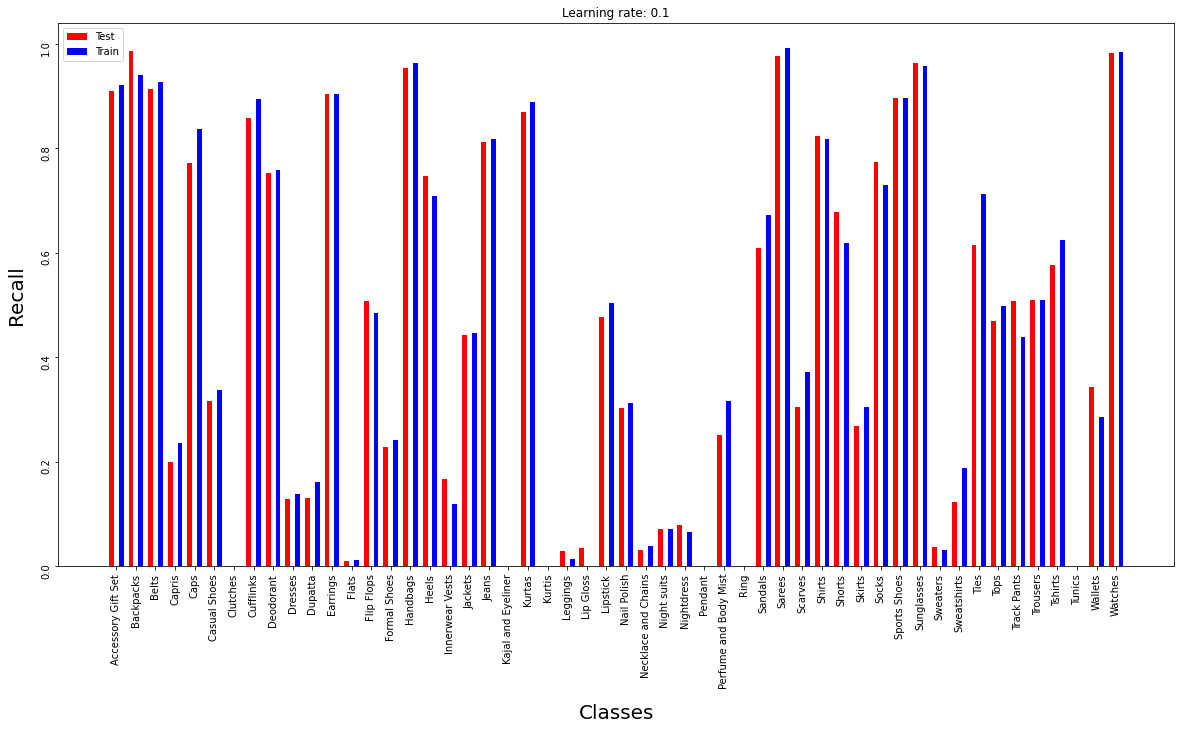

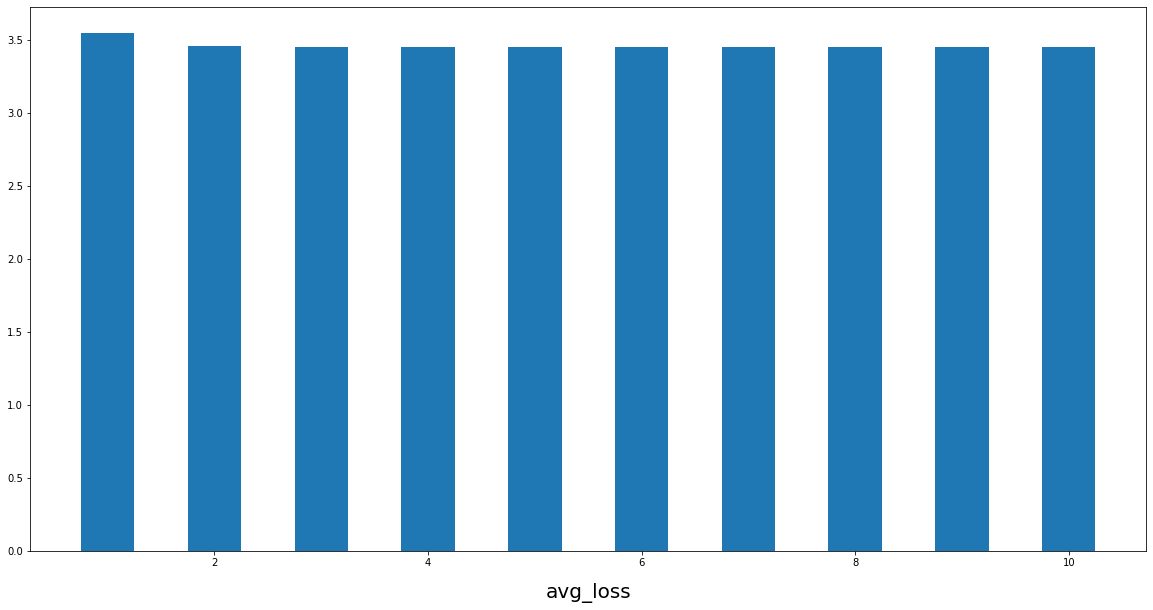

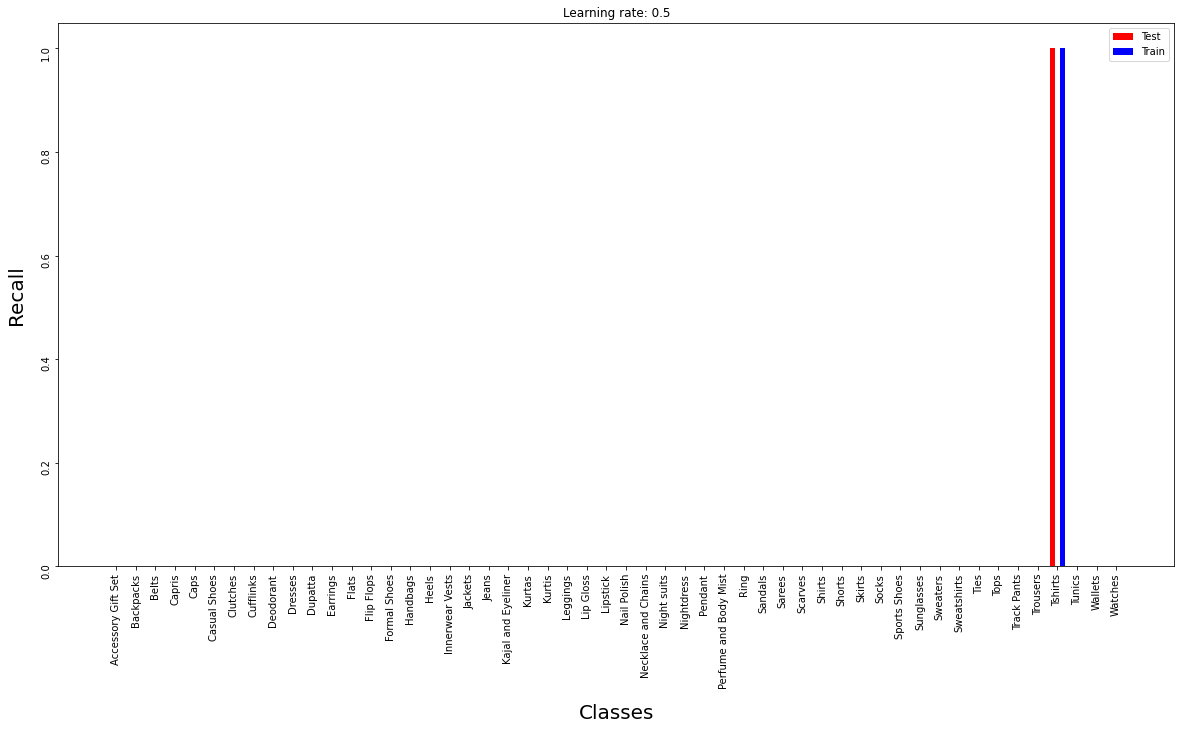

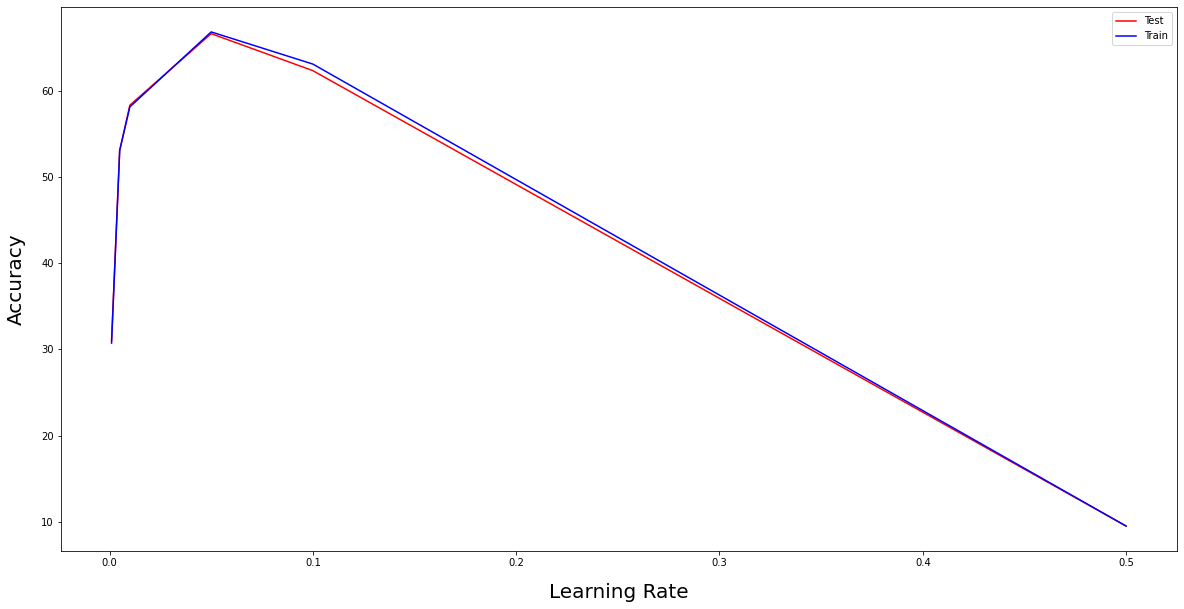

In [ ]:
def get_part_6_results(dataset, layer_inputs, criterion, train_loader, test_loader):

    learning_rates = [
        0.001,
        0.005,
        0.01,
        0.05,
        0.1,
        0.5
    ]

    test_results = []
    train_results = []
    optimized_learning_rate = None
    max_accuracy = 0

    for _learning_rate in learning_rates:
        print(f'Training network with learning rate: {_learning_rate}')
        optimized_network = VariableLayerModel(dataset.classes, layer_inputs)
        optimized_network = optimized_network.to(device)
        optimizer = torch.optim.SGD(optimized_network.parameters(), lr=_learning_rate)
        fit(optimized_network, train_loader, device, criterion, optimizer)
        print('Test Accuracy:')
        test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network, test_loader, dataset.classes)
        print('Train Accuracy')
        train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network, train_loader, dataset.classes)

        if test_accuracy > max_accuracy:
            max_accuracy = test_accuracy
            optimized_learning_rate = _learning_rate
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
        plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes, title=f'Learning rate: {_learning_rate}')
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(learning_rates, test_results, color='r')
    ax.plot(learning_rates, train_results, color='b')
    ax.set_xlabel("Learning Rate",labelpad=15, size=20)
    ax.set_ylabel("Accuracy",labelpad=15, size=20)
    plt.legend(["Test", "Train"])
    return optimized_learning_rate

optimized_learning_rate = get_part_6_results(normalized_dataset, optimized_layer_inputs, DEFAULT_LOSS_FUNCTION, normalized_train_loader, normalized_test_loader)

In [ ]:
print(f'The optimized learning rate is: {optimized_learning_rate}')

The optimized learning rate is: 0.05


As seen in the plot above, the learning rate value of 0.05 yields the best accuracy. However, if the learning rate is too low (e.g. 0.001) or too high (e.g. 0.5) the accuracy falls dramatically. The reasons are explained below.

### Part 6.2.
If the learning rate is too high, it can cause unstabilities and divergency as it makes big updates to the weights each time and on the other hand, if the learning rate is too low it makes very small changes to the weights and requires a large number of updates in order to reach the minimum. The picture below illustrates the effects of a too high or too low value for the learning rate parameter.
![alt text](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

## Part 7.
The effect of the batch size parameter will be analyzed.

### Part 7.1.


Training with batch size: 32
epoch 1, train_loss: 2.388, time elapsed: 22.946352 seconds
epoch 2, train_loss: 1.628, time elapsed: 22.983214 seconds
epoch 3, train_loss: 1.377, time elapsed: 23.080865 seconds
epoch 4, train_loss: 1.237, time elapsed: 22.976299 seconds
epoch 5, train_loss: 1.152, time elapsed: 23.021377 seconds
epoch 6, train_loss: 1.075, time elapsed: 23.140914 seconds
epoch 7, train_loss: 1.032, time elapsed: 23.086796 seconds
epoch 8, train_loss: 0.972, time elapsed: 23.053372 seconds
epoch 9, train_loss: 0.943, time elapsed: 22.989936 seconds
epoch 10, train_loss: 0.899, time elapsed: 23.128706 seconds
total training time: 3.840 minutes
Test Accuracy:
Accuracy: 61.40939597315436%
Train Accuracy:
Accuracy: 63.139702674586395%
Training with batch size: 128
epoch 1, train_loss: 2.933, time elapsed: 13.776048 seconds
epoch 2, train_loss: 2.197, time elapsed: 13.757406 seconds
epoch 3, train_loss: 1.854, time elapsed: 13.762905 seconds
epoch 4, train_loss: 1.629, time el

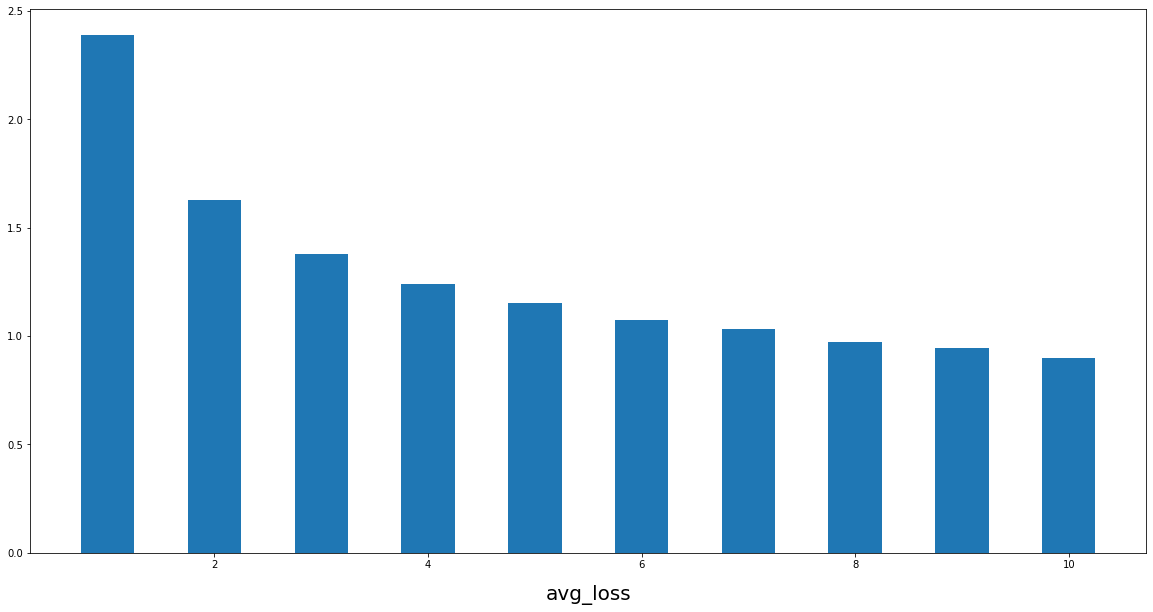

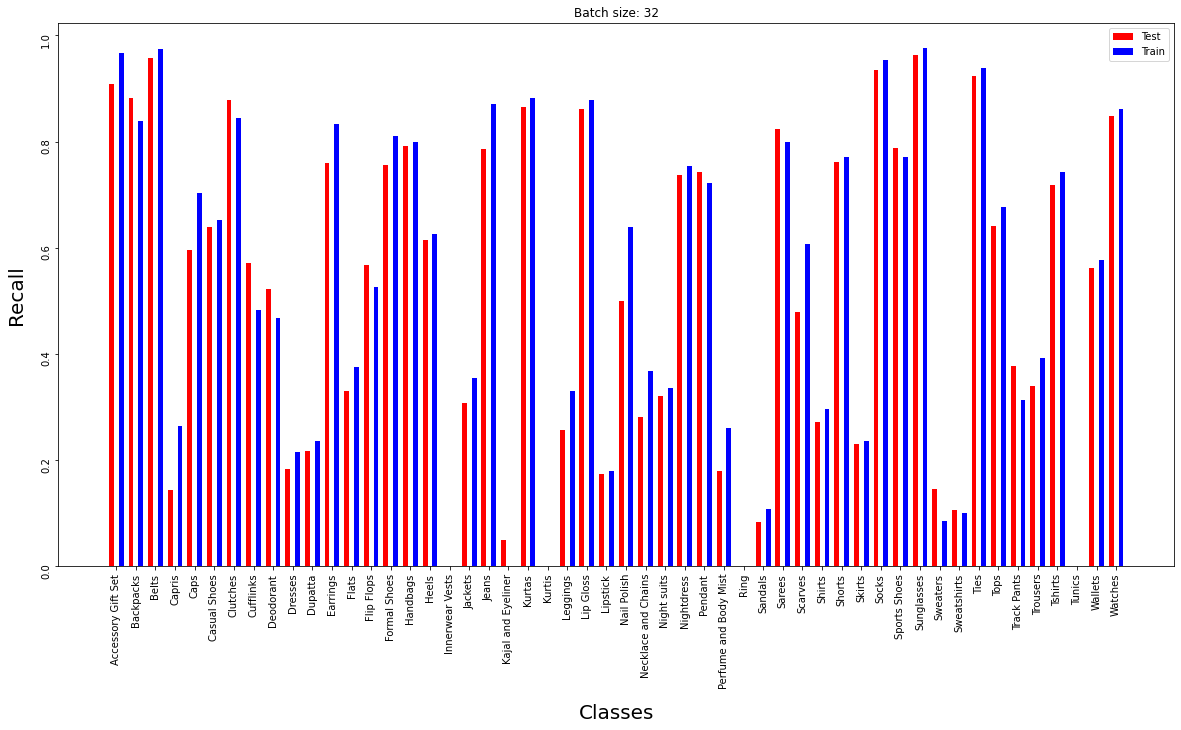

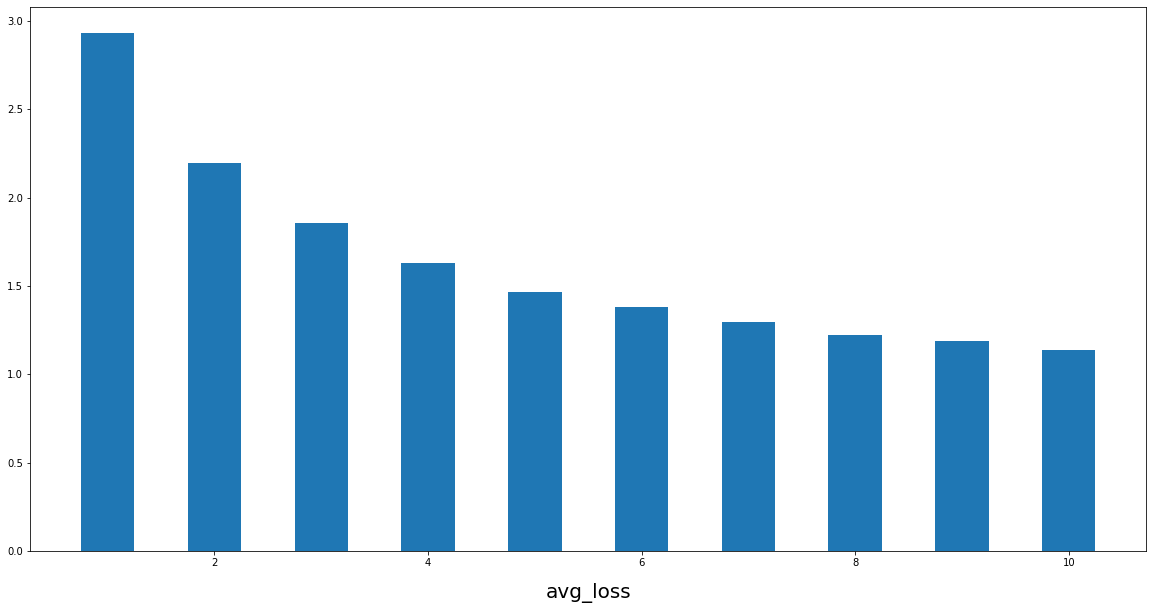

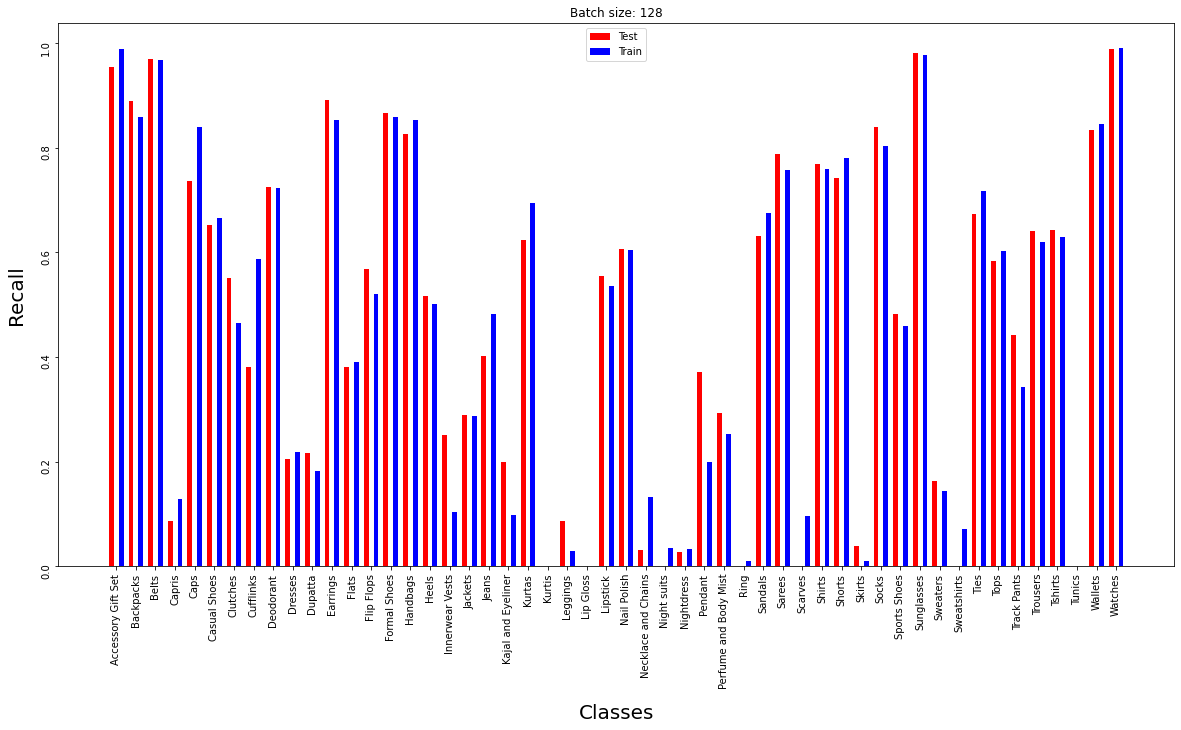

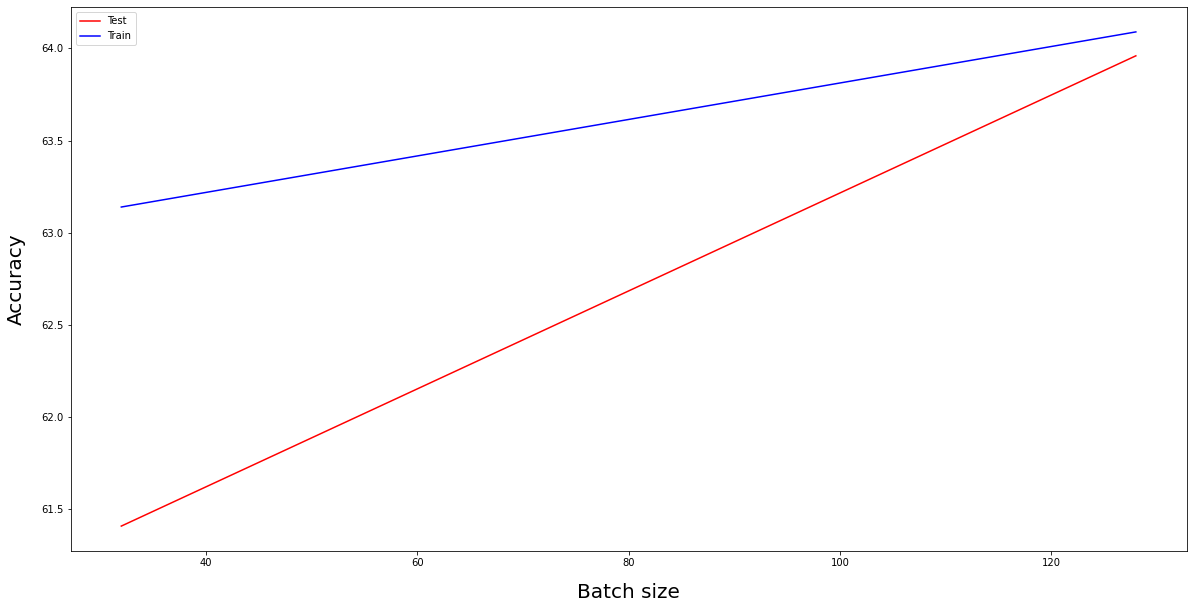

In [ ]:
def get_part_7_1_results(dataset, layer_inputs, criterion, learning_rate, train_indices, test_indices):
    batch_sizes = [
        32,
        128,
    ]

    test_results = []
    train_results = []

    for _batch_size in batch_sizes:
        print(f'Training with batch size: {_batch_size}')
        optimized_network = VariableLayerModel(dataset.classes, layer_inputs)
        optimized_network = optimized_network.to(device)

        _train_sampler = SubsetRandomSampler(train_indices)
        _test_sampler = SubsetRandomSampler(test_indices)

        _train_loader = torch.utils.data.DataLoader(dataset, batch_size=_batch_size, sampler=_train_sampler, num_workers=16)
        _test_loader = torch.utils.data.DataLoader(dataset, batch_size=_batch_size, sampler=_test_sampler, num_workers=16)
        optimizer = torch.optim.SGD(optimized_network.parameters(), lr=learning_rate)
        fit(optimized_network, _train_loader, device, criterion, optimizer)
        print('Test Accuracy:')
        test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network, _test_loader, dataset.classes)
        print('Train Accuracy:')
        train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network, _train_loader, dataset.classes)
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
        plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes, title=f'Batch size: {_batch_size}')
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(batch_sizes, test_results, color='r')
    ax.plot(batch_sizes, train_results, color='b')
    ax.set_xlabel("Batch size",labelpad=15, size=20)
    ax.set_ylabel("Accuracy",labelpad=15, size=20)
    plt.legend(["Test", "Train"])

get_part_7_1_results(normalized_dataset, optimized_layer_inputs, DEFAULT_LOSS_FUNCTION, optimized_learning_rate, normalized_train_indices, normalized_test_indices)

As seen in the results above, the batch size has not affected the accuracy of the model considerably (neither in a good way nor a bad one.) However, batch size can have sensible effects on other models. While using bigger batch size values can benefit more from the parallelism of the GPUs and, tends to converge to the global optima of the objective function (especially when equal to the dataset size); it also causes slower converging time. Using smaller batch sizes usually yield smaller converging times and good (but not globally optimal) solutions. Another benefit of using small batch sizes is that it prevents overfitting and gives more generalization to the model as the model sees a smaller number of data pieces each time and, as each batch has some noise, the model can't overfit the data as opposed to when the whole dataset is given to the model, drastically decreasing the effects of the noise.

### Part 7.2.

Training with batch size: 128 and learning rate: 0.001
epoch 1, train_loss: 3.840, time elapsed: 13.774475 seconds
epoch 2, train_loss: 3.590, time elapsed: 13.774641 seconds
epoch 3, train_loss: 3.461, time elapsed: 13.980856 seconds
epoch 4, train_loss: 3.404, time elapsed: 13.863858 seconds
epoch 5, train_loss: 3.356, time elapsed: 13.855514 seconds
epoch 6, train_loss: 3.302, time elapsed: 13.776049 seconds
epoch 7, train_loss: 3.240, time elapsed: 13.794062 seconds
epoch 8, train_loss: 3.170, time elapsed: 13.93932 seconds
epoch 9, train_loss: 3.098, time elapsed: 13.875816 seconds
epoch 10, train_loss: 3.030, time elapsed: 13.842128 seconds
total training time: 2.308 minutes
Test Accuracy:
Accuracy: 20.778523489932887%
Train Accuracy
Accuracy: 20.859760394644116%
Training with batch size: 128 and learning rate: 0.05
epoch 1, train_loss: 2.910, time elapsed: 13.86622 seconds
epoch 2, train_loss: 2.184, time elapsed: 13.834956 seconds
epoch 3, train_loss: 1.837, time elapsed: 13.83

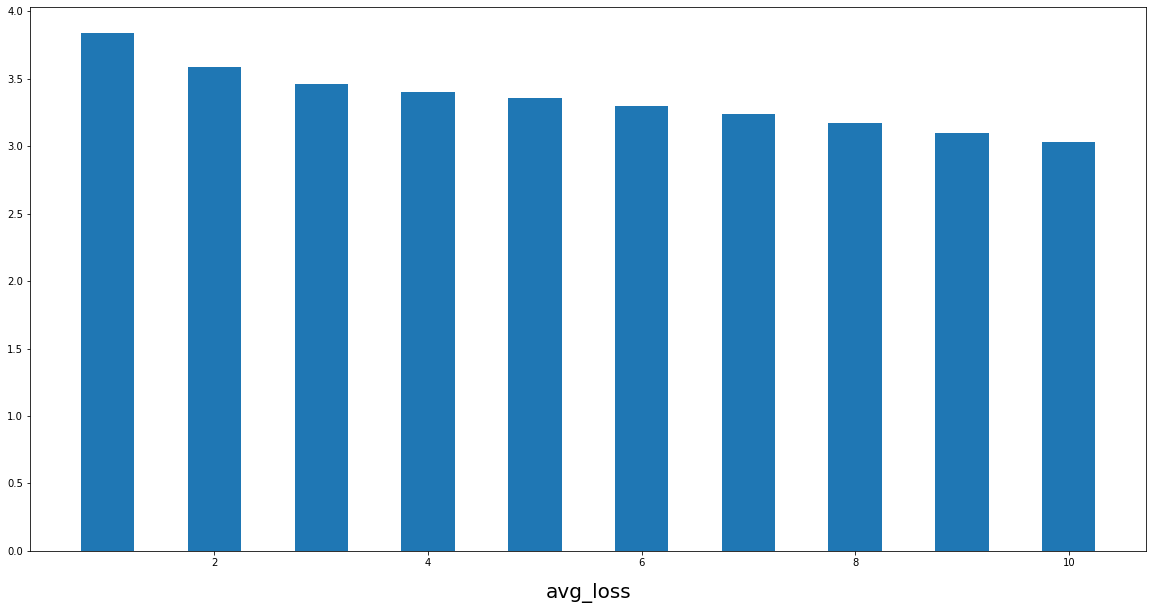

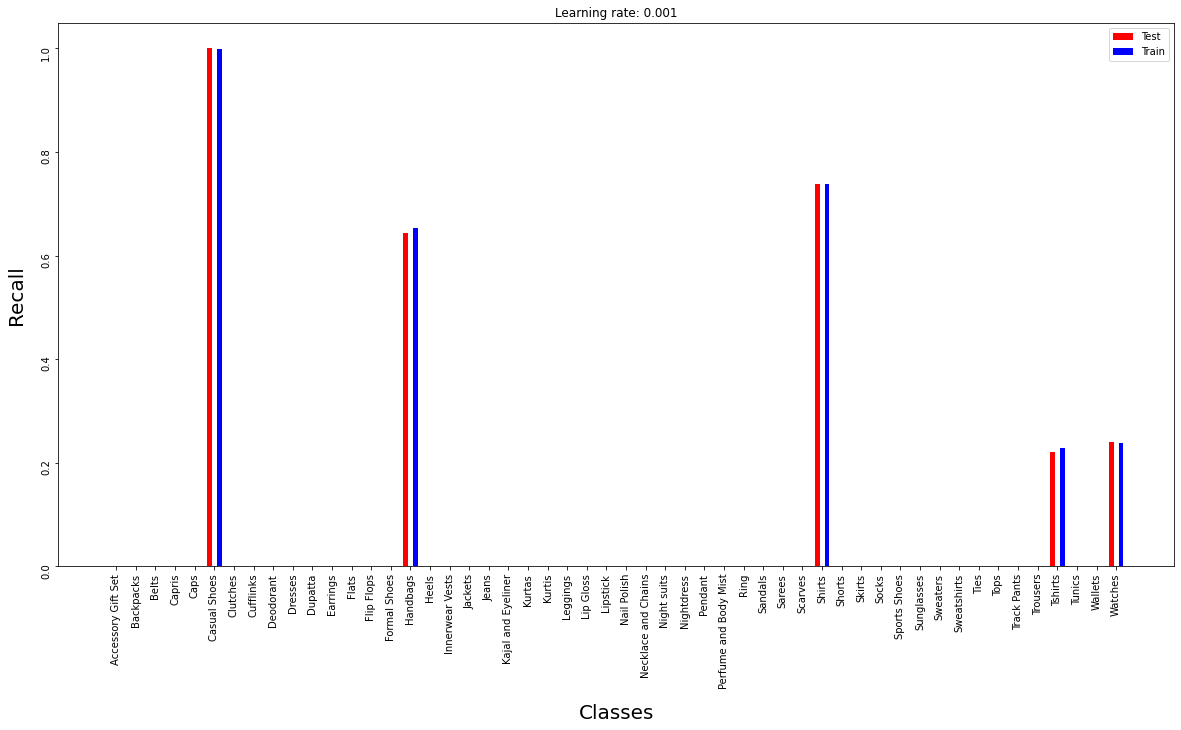

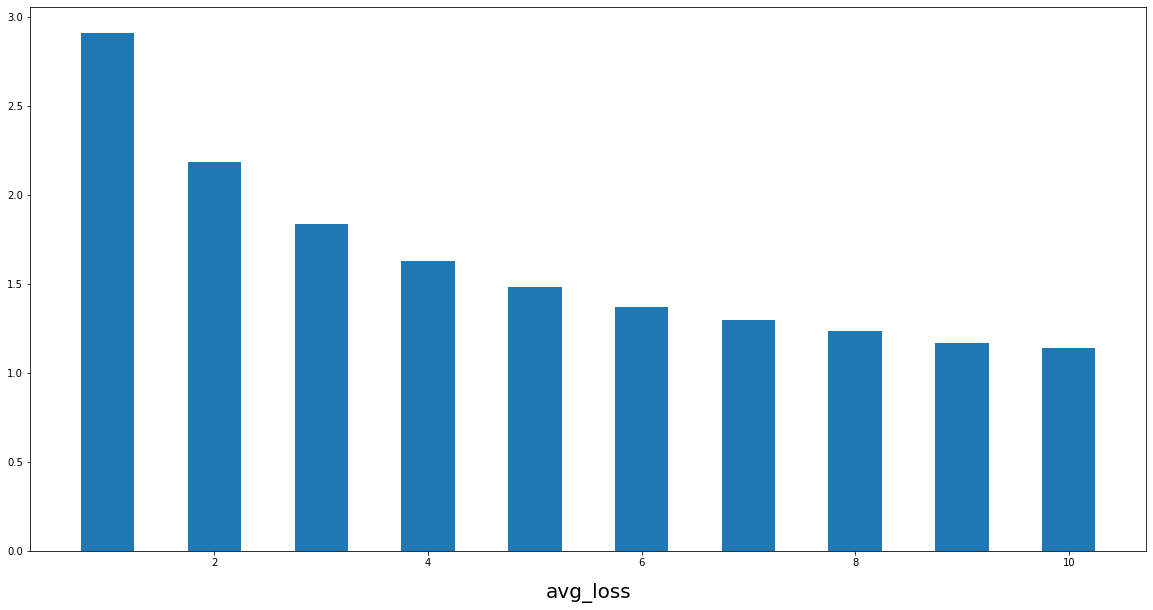

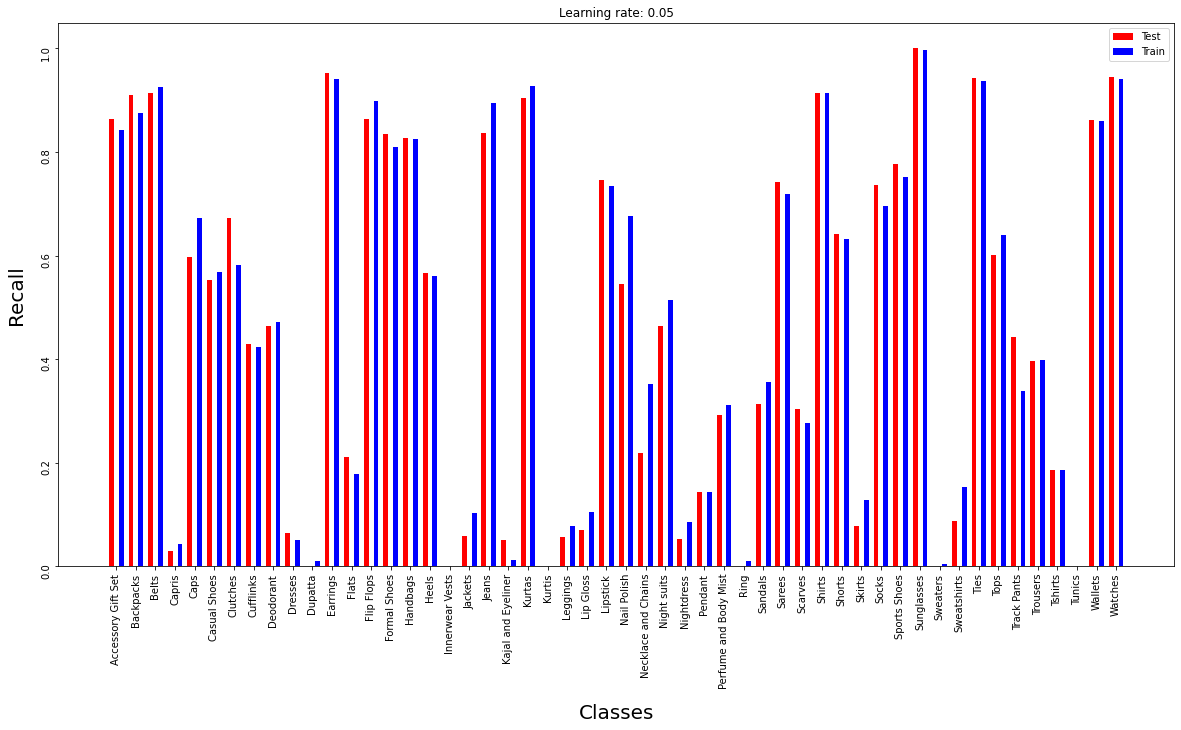

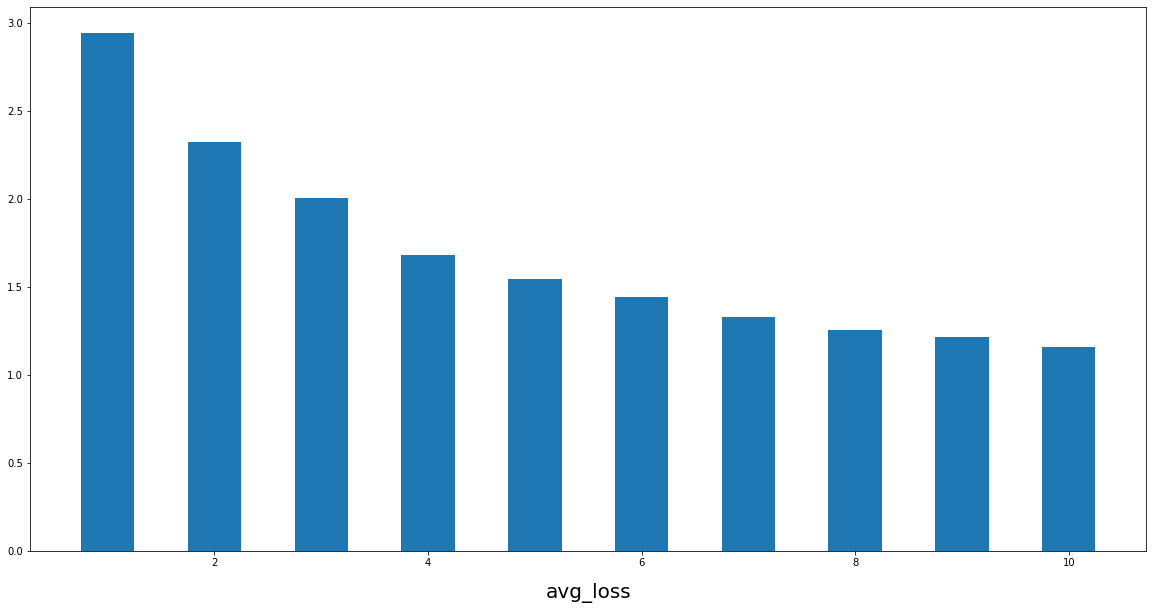

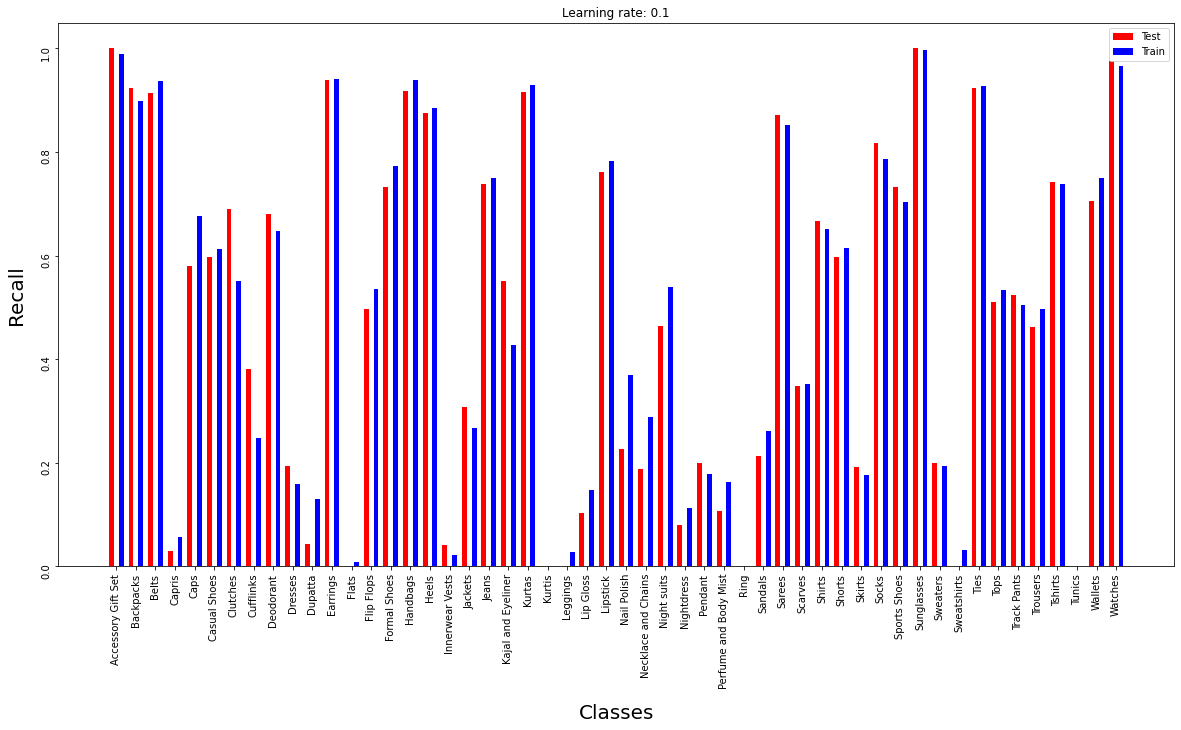

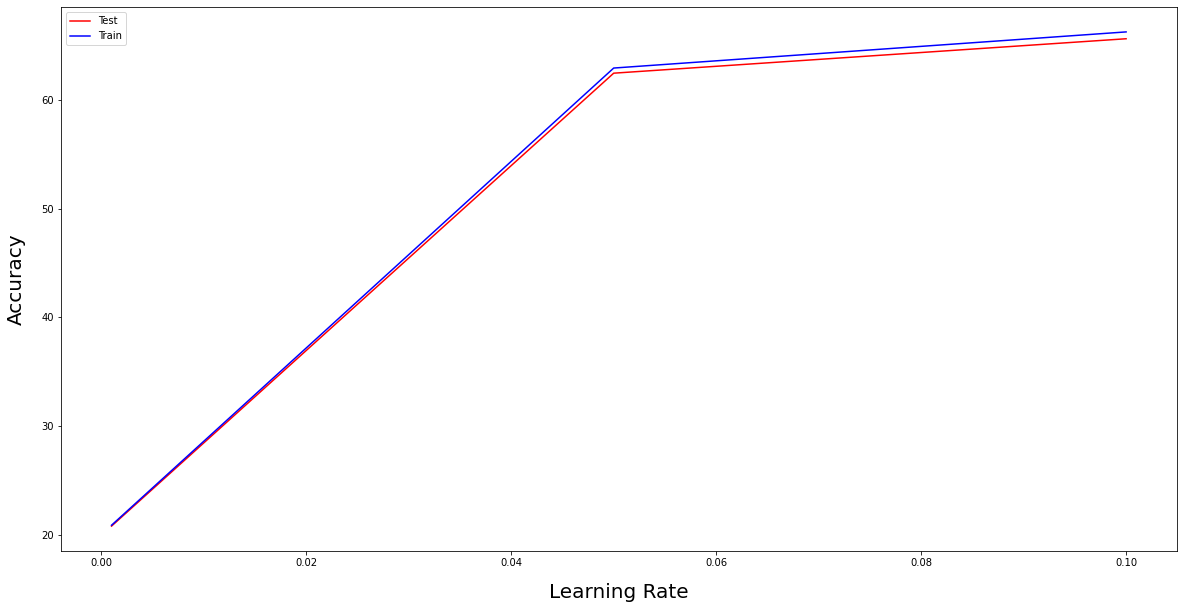

In [ ]:
def get_part_7_2_results(dataset, layer_inputs, criterion, train_indices, test_indices):
    batch_size = 128

    learning_rates = [
        0.001,
        0.05,
        0.1,
    ]

    test_results = []
    train_results = []

    _train_sampler = SubsetRandomSampler(train_indices)
    _test_sampler = SubsetRandomSampler(test_indices)

    _train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=_train_sampler, num_workers=16)
    _test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=_test_sampler, num_workers=16)

    for _learning_rate in learning_rates:
        print(f'Training with batch size: 128 and learning rate: {_learning_rate}')
        optimized_network = VariableLayerModel(dataset.classes, layer_inputs)
        optimized_network = optimized_network.to(device)
        optimizer = torch.optim.SGD(optimized_network.parameters(), lr=_learning_rate)
        fit(optimized_network, _train_loader, device, criterion, optimizer)
        print('Test Accuracy:')
        test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network, _test_loader, dataset.classes)
        print('Train Accuracy')
        train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network, _train_loader, dataset.classes)
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
        plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes, title=f'Learning rate: {_learning_rate}')
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(learning_rates, test_results, color='r')
    ax.plot(learning_rates, train_results, color='b')
    ax.set_xlabel("Learning Rate",labelpad=15, size=20)
    ax.set_ylabel("Accuracy",labelpad=15, size=20)
    plt.legend(["Test", "Train"])

get_part_7_2_results(normalized_dataset, optimized_layer_inputs, DEFAULT_LOSS_FUNCTION, normalized_train_indices, normalized_test_indices)

In larger batch sizes, higher learning rates may result in more accurate models. As the batch size increases, the model observes more data and less noise and as a result it can update it weights more accurately and with more confidence, which is why higher learning rates are better as the batch size increases. The opposite is true too, as the model observes less data, which include more noise, it should carefully (and with smaller steps) update it's weights to prevent diverging.

## Part 8.
Analyzing the momentum parameter

### Part 8.1.

When momentum is used, our updates will depend on the previous weight to an extent (which depends on the momentum value.) this can cause the model to converge faster, if the value is tuned correctly, or to miss the minimum completely if the value is too high. The usage of momentum is based on this formula:

$V_t = \beta V_{t-1} + (1 - \beta)S_t$ 

In which, $\beta$ is the momentum value, and $V_t$ is the gradient value of this step.
Momentum can cause faster converging and prevent getting stuck on local minimums if tuned, but otherwise, might cause the model to miss the optimal minimum altogether.

### Part 8.2.

Training network with momentum: 0.5
epoch 1, train_loss: 2.420, time elapsed: 18.424795 seconds
epoch 2, train_loss: 1.716, time elapsed: 18.401068 seconds
epoch 3, train_loss: 1.437, time elapsed: 18.277873 seconds
epoch 4, train_loss: 1.273, time elapsed: 18.45246 seconds
epoch 5, train_loss: 1.197, time elapsed: 18.341729 seconds
epoch 6, train_loss: 1.106, time elapsed: 18.439277 seconds
epoch 7, train_loss: 1.052, time elapsed: 18.428194 seconds
epoch 8, train_loss: 1.022, time elapsed: 18.379306 seconds
epoch 9, train_loss: 0.969, time elapsed: 18.271404 seconds
epoch 10, train_loss: 0.931, time elapsed: 18.446907 seconds
total training time: 3.064 minutes
Test Accuracy:
Accuracy: 65.85234899328859%
Train Accuracy:
Accuracy: 66.77740863787375%
Training network with momentum: 0.9
epoch 1, train_loss: 3.380, time elapsed: 18.351917 seconds
epoch 2, train_loss: 3.456, time elapsed: 18.440634 seconds
epoch 3, train_loss: 3.452, time elapsed: 18.299062 seconds
epoch 4, train_loss: 3.4

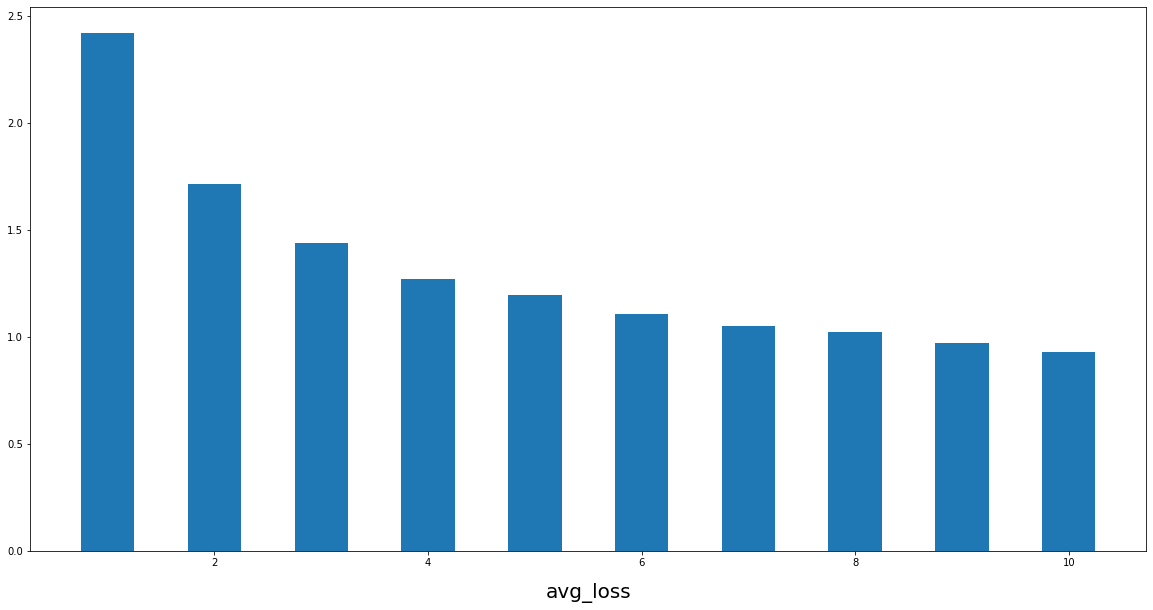

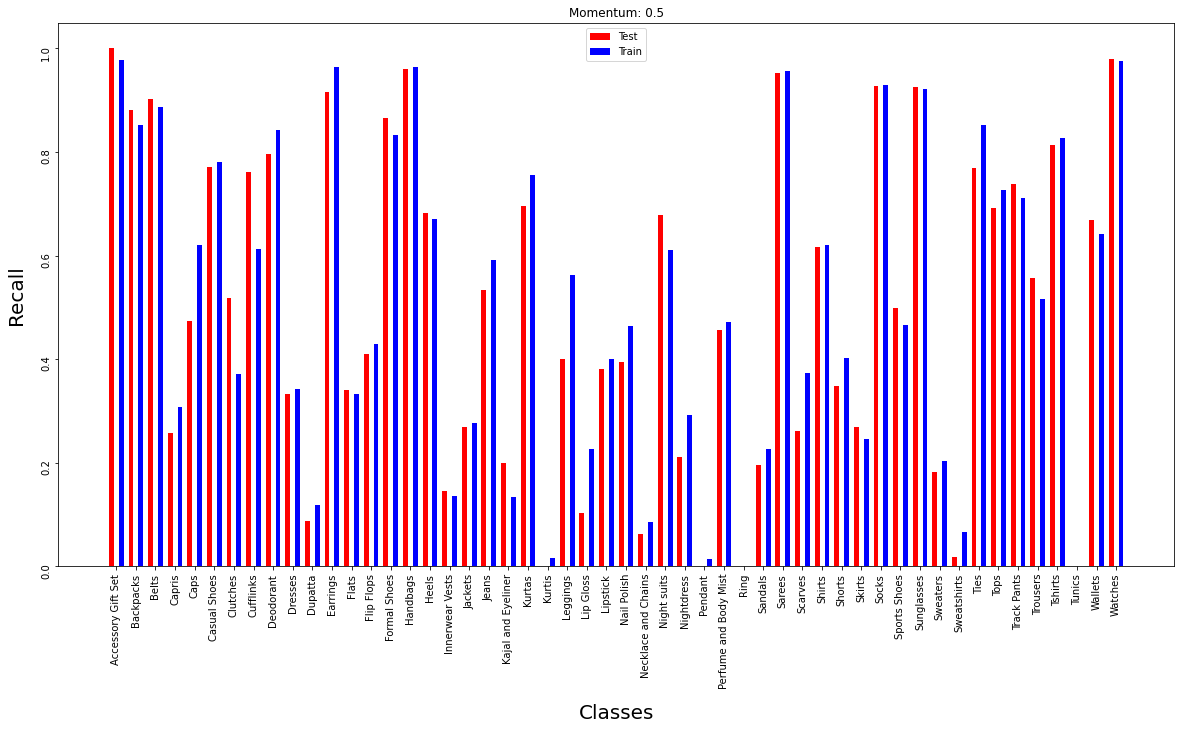

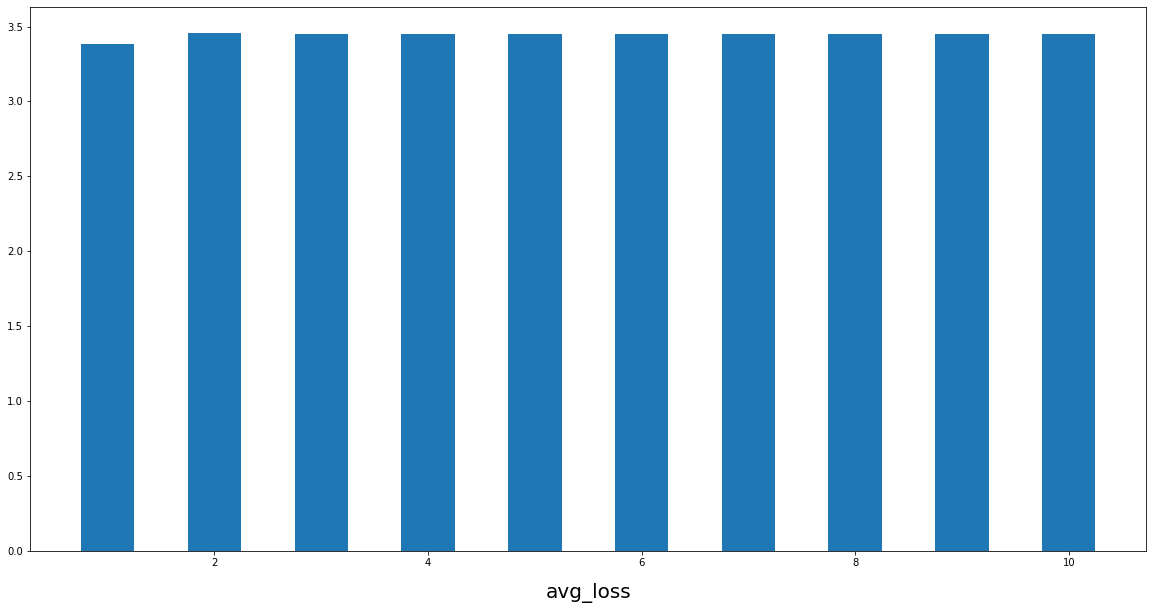

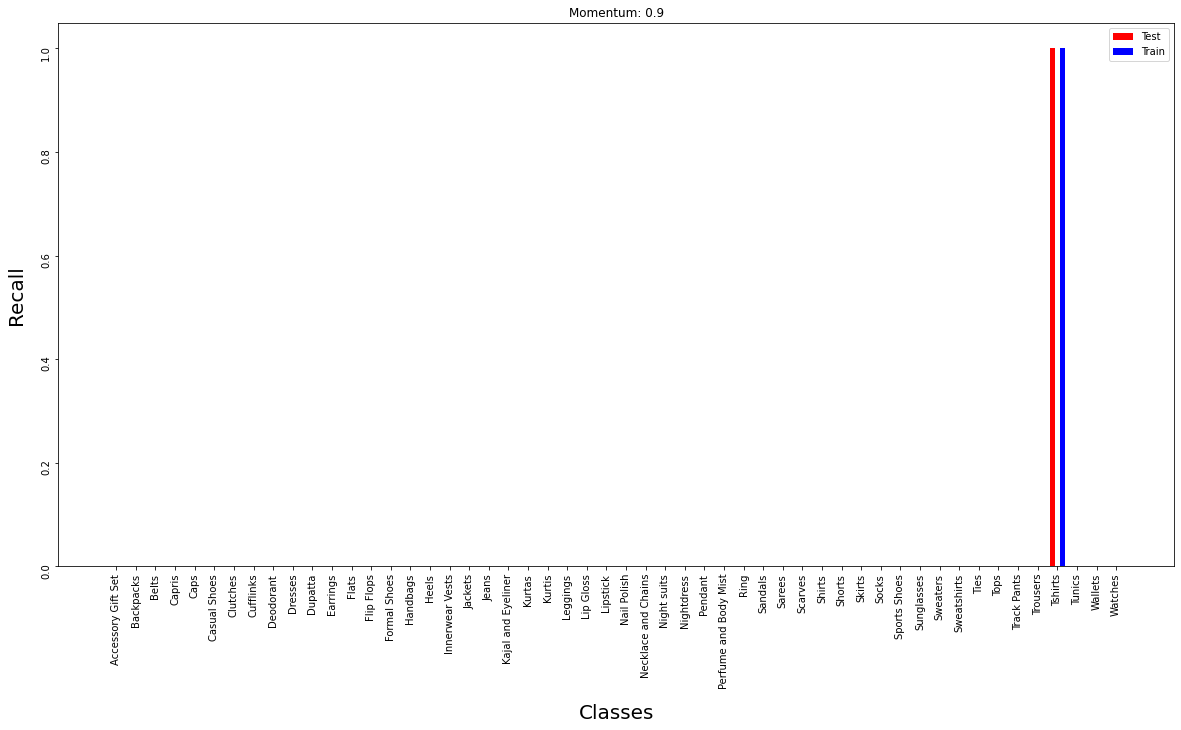

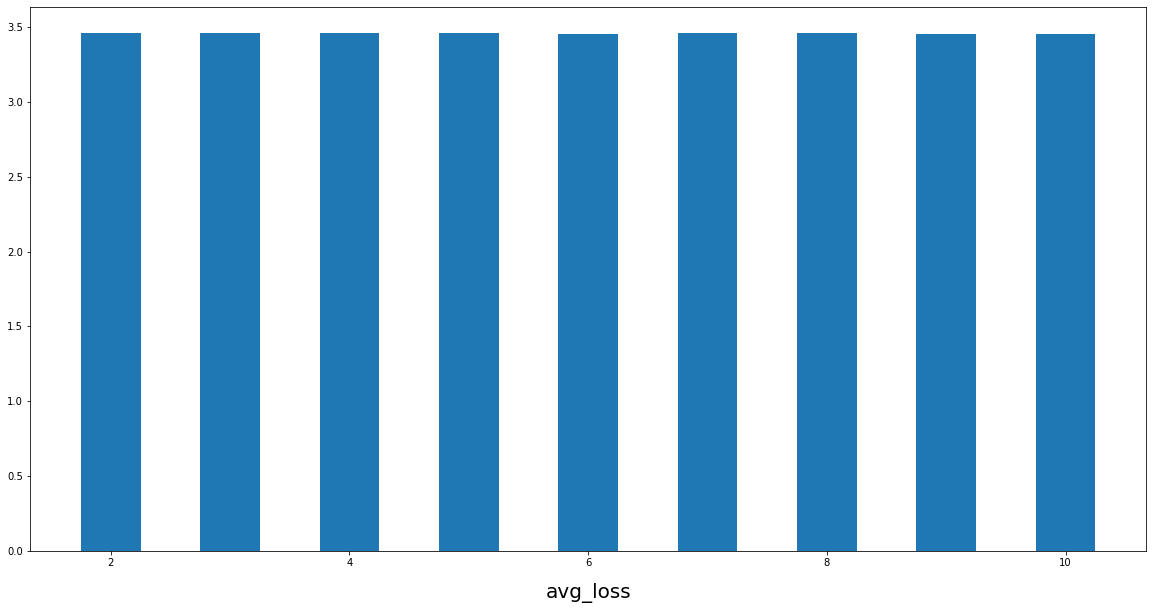

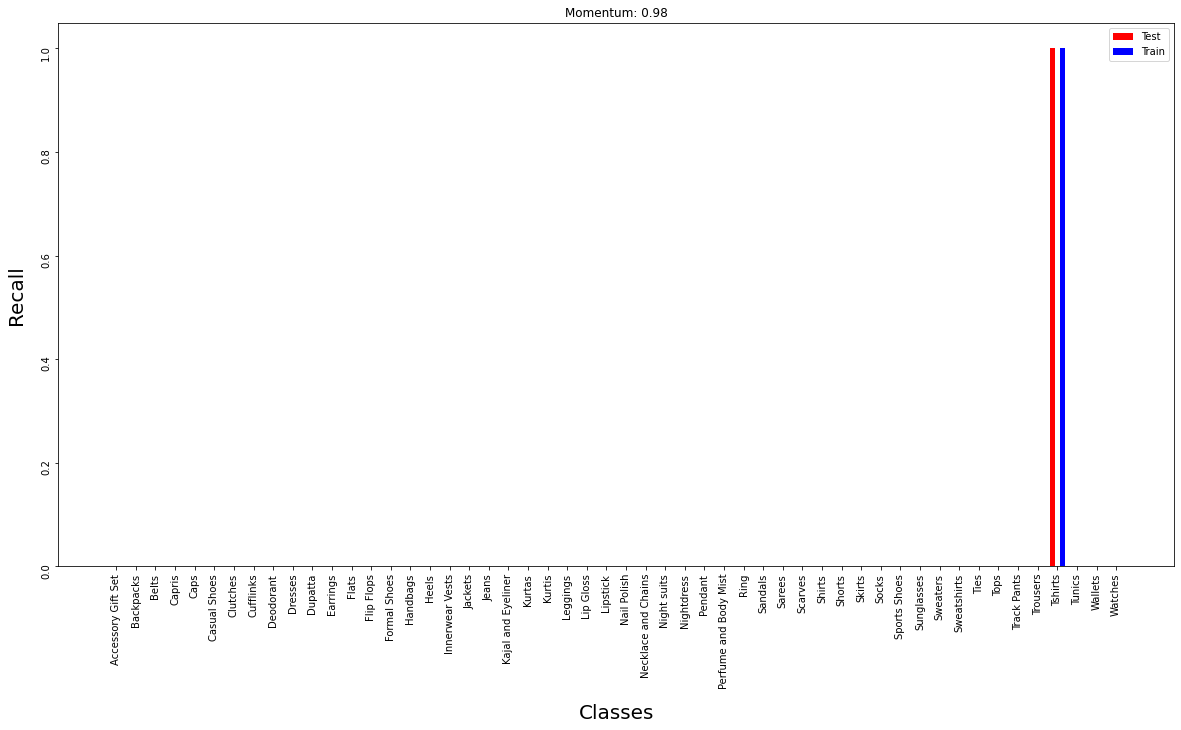

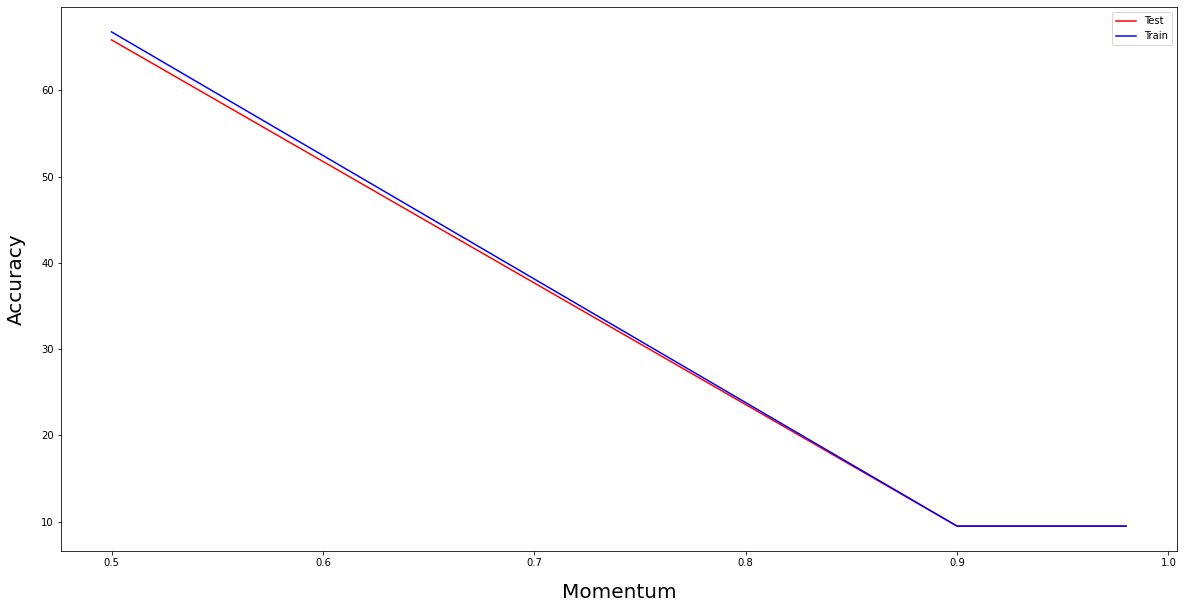

In [ ]:
def get_part_8_results(dataset, layer_inputs, criterion, learning_rate, train_loader, test_loader):


    test_results = []
    train_results = []
    optimized_momentum = None
    max_accuracy = 0

    momentum_values = [
        0.5,
        0.9,
        0.98,    
    ]

    for momentum in momentum_values:
        print(f'Training network with momentum: {momentum}')
        optimized_network = VariableLayerModel(dataset.classes, layer_inputs)
        optimized_network = optimized_network.to(device)
        optimizer = torch.optim.SGD(optimized_network.parameters(), lr=learning_rate, momentum=momentum)
        fit(optimized_network, train_loader, device, criterion, optimizer)
        print('Test Accuracy:')
        test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network, test_loader, dataset.classes)
        print('Train Accuracy:')
        train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network, train_loader, dataset.classes)
        if test_accuracy > max_accuracy:
            max_accuracy = test_accuracy
            optimized_momentum = momentum   
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
        plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes, title=f'Momentum: {momentum}')
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(momentum_values, test_results, color='r')
    ax.plot(momentum_values, train_results, color='b')
    ax.set_xlabel("Momentum",labelpad=15, size=20)
    ax.set_ylabel("Accuracy",labelpad=15, size=20)
    plt.legend(["Test", "Train"])
    return optimized_momentum

optimized_momentum = get_part_8_results(normalized_dataset, optimized_layer_inputs, DEFAULT_LOSS_FUNCTION, optimized_learning_rate, normalized_train_loader, normalized_test_loader)

In [ ]:
optimized_momentum

0.5

As seen above, the model works perfectly well with a momentum value of 0.5 while the results collapse when using 0.9 or 0.98 as the momentum value, the results will be dependent on the previous weights more than they should be, and it prevents the model from training as desired.

### Part 8.3.

As stated above, increasing the momentum won't always result in better accuracy and more precise training process. It can even cause the accuracy of the model to fall as it has in this assignment. The initial weights are usually random and if they have more weight than they should in the updating process, they may make the training process too slow and prevent the training from progressing.

## Part 9.
Effects of epoch count on the results.

### Part 9.1.

Training network with epoch count: 10
epoch 1, train_loss: 2.405, time elapsed: 18.374061 seconds
epoch 2, train_loss: 1.799, time elapsed: 18.427974 seconds
epoch 3, train_loss: 1.462, time elapsed: 18.460346 seconds
epoch 4, train_loss: 1.304, time elapsed: 18.335056 seconds
epoch 5, train_loss: 1.194, time elapsed: 18.310193 seconds
epoch 6, train_loss: 1.119, time elapsed: 18.413245 seconds
epoch 7, train_loss: 1.059, time elapsed: 18.410792 seconds
epoch 8, train_loss: 1.004, time elapsed: 18.339131 seconds
epoch 9, train_loss: 0.971, time elapsed: 18.389777 seconds
epoch 10, train_loss: 0.936, time elapsed: 18.358171 seconds
total training time: 3.064 minutes
Accuracy: 61.43624161073826%
Accuracy: 62.70344642437666%
Training network with epoch count: 20
epoch 1, train_loss: 2.437, time elapsed: 18.510455 seconds
epoch 2, train_loss: 1.679, time elapsed: 18.378769 seconds
epoch 3, train_loss: 1.430, time elapsed: 18.740984 seconds
epoch 4, train_loss: 1.286, time elapsed: 18.41379

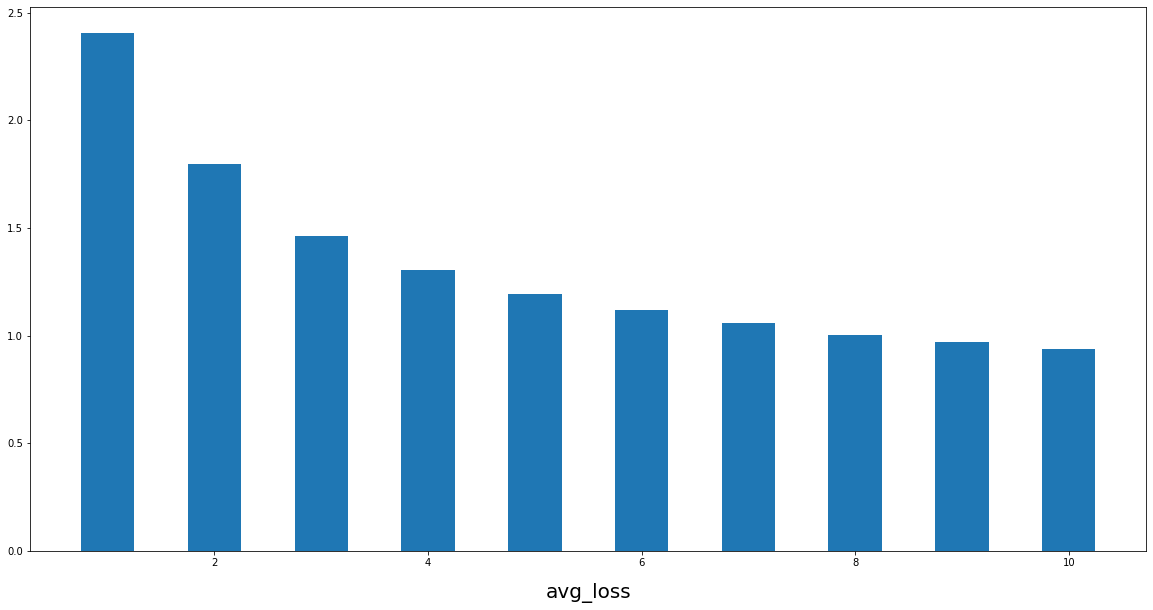

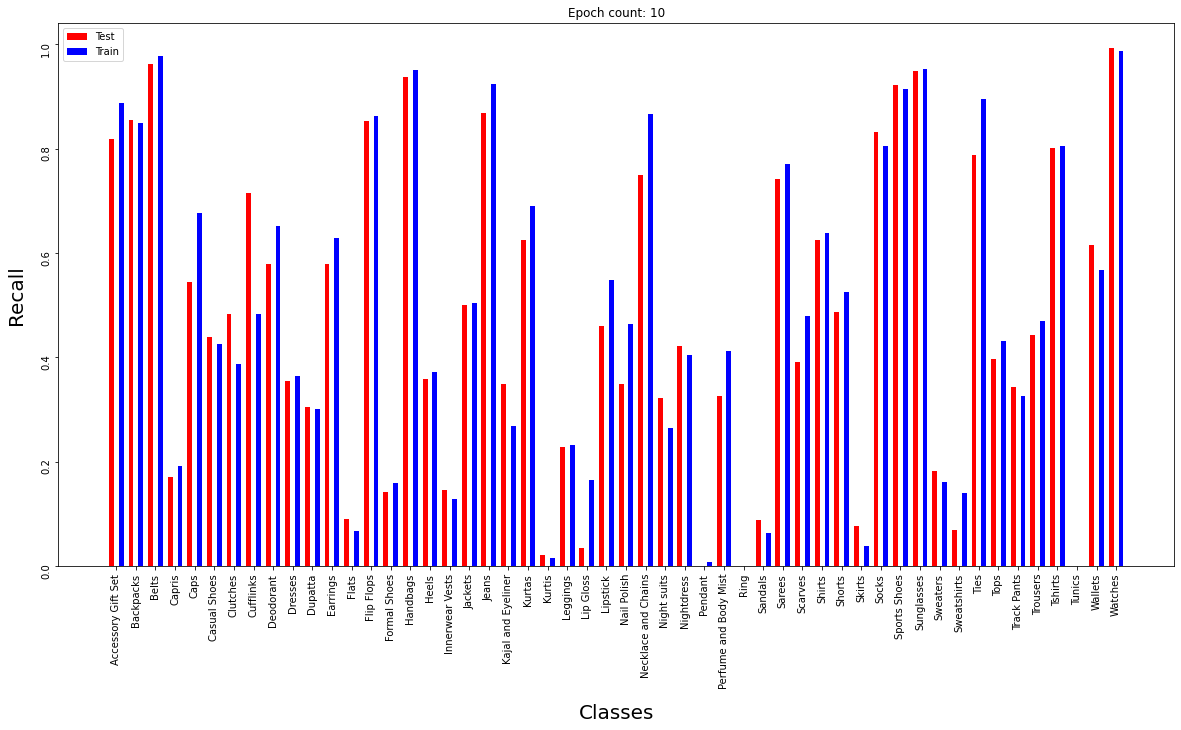

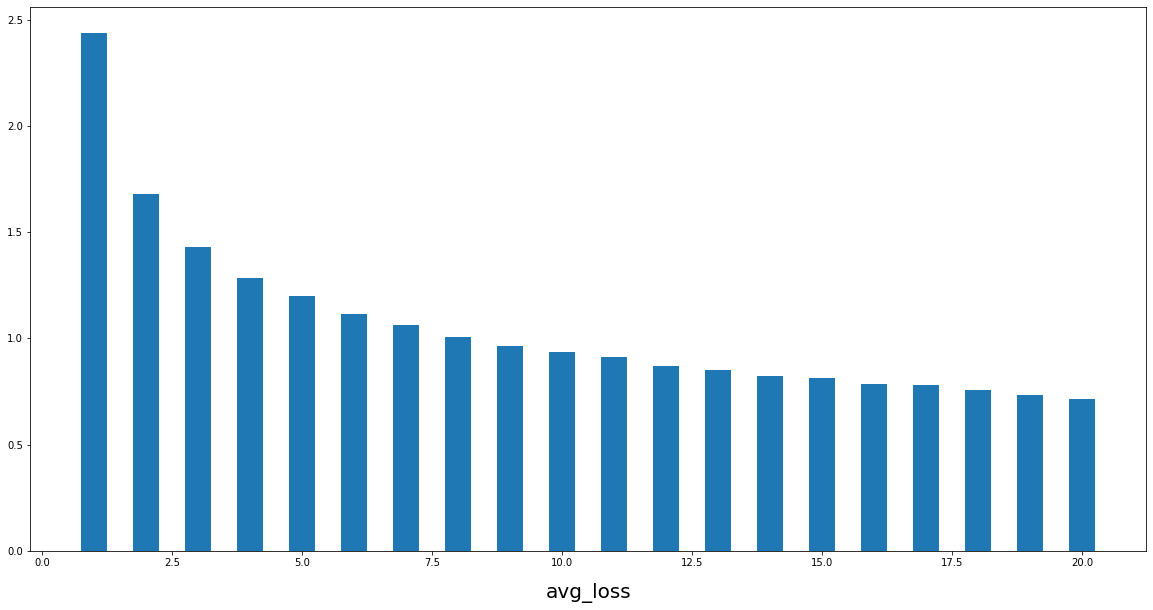

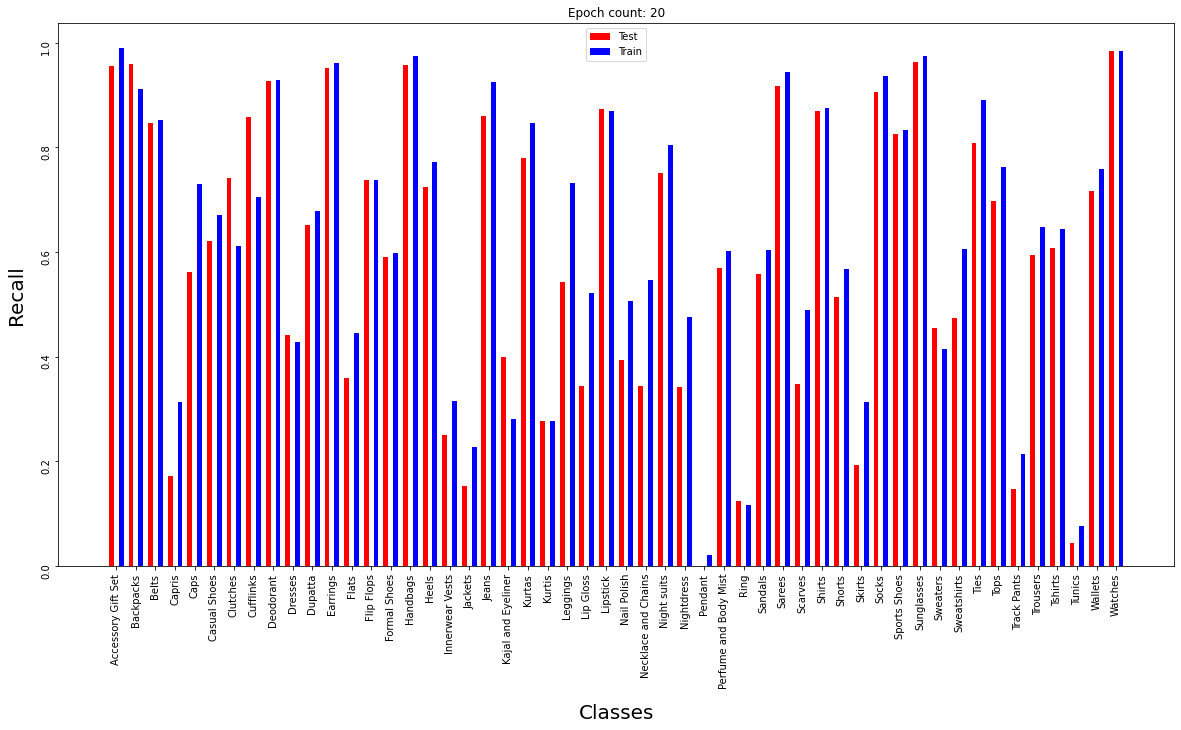

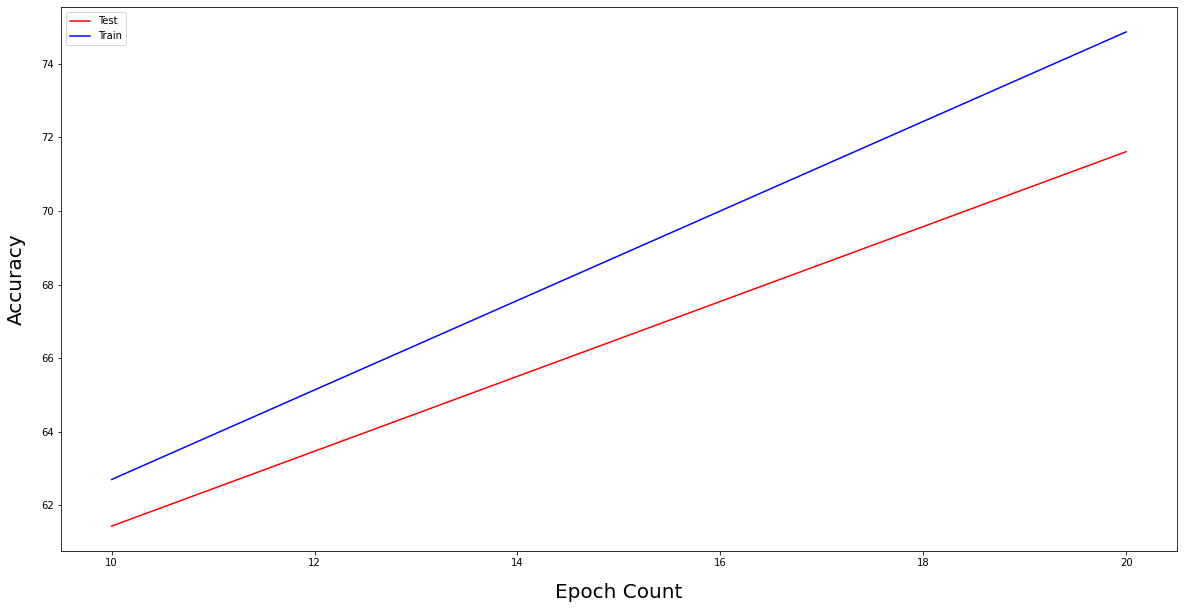

In [ ]:
def get_part_9_results(dataset, layer_inputs, criterion, learning_rate, momentum, train_loader, test_loader):


    test_results = []
    train_results = []
    epoch_count = [
        10,
        20,    
    ]

    for epoch in epoch_count:
        print(f'Training network with epoch count: {epoch}')
        optimized_network = VariableLayerModel(dataset.classes, layer_inputs)
        optimized_network = optimized_network.to(device)
        optimizer = torch.optim.SGD(optimized_network.parameters(), lr=learning_rate, momentum=momentum)
        fit(optimized_network, train_loader, device, criterion, optimizer, num_epochs=epoch)
        test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network, test_loader, dataset.classes)
        train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network, train_loader, dataset.classes)
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
        plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes, title=f'Epoch count: {epoch}')
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(epoch_count, test_results, color='r')
    ax.plot(epoch_count, train_results, color='b')
    ax.set_xlabel("Epoch Count",labelpad=15, size=20)
    ax.set_ylabel("Accuracy",labelpad=15, size=20)
    plt.legend(["Test", "Train"])

get_part_9_results(normalized_dataset, optimized_layer_inputs, DEFAULT_LOSS_FUNCTION, optimized_learning_rate, optimized_momentum, normalized_train_loader, normalized_test_loader)

When looking at the plot drawn in this part, we can see that increasing the epoch count has increased the accuracy of our model, which seems logical as the training process of the model is longer and it observes more data.

### Part 9.2.

Algorithms like SGD, are iterative, they can't find the optimal minimum in one pass and they get better results with every pass so more than one epoch is needed so that the model can reach the desired result.

### Part 9.3.

Increasing the epoch count won't necessarily give better results. One of the main problems of having a large epoch count is overfitting. The model observes the training data more than it should, and it overfits and yields great results on the test dataset, but can't predict equally as well when tested with datasets not previously observed.

## Part 10.
Different activation functions will be used and the results will be checked below.

Training network with activation function: relu
epoch 1, train_loss: 2.491, time elapsed: 18.643597 seconds
epoch 2, train_loss: 1.732, time elapsed: 18.424114 seconds
epoch 3, train_loss: 1.436, time elapsed: 18.557008 seconds
epoch 4, train_loss: 1.291, time elapsed: 18.391313 seconds
epoch 5, train_loss: 1.195, time elapsed: 18.586917 seconds
epoch 6, train_loss: 1.126, time elapsed: 18.440508 seconds
epoch 7, train_loss: 1.073, time elapsed: 18.499425 seconds
epoch 8, train_loss: 1.013, time elapsed: 18.303702 seconds
epoch 9, train_loss: 0.978, time elapsed: 18.599663 seconds
epoch 10, train_loss: 0.940, time elapsed: 18.291894 seconds
total training time: 3.079 minutes
Accuracy: 67.11409395973155%
Accuracy: 67.9922145038424%
Training network with activation function: tanh


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 2.087, time elapsed: 18.506068 seconds
epoch 2, train_loss: 1.399, time elapsed: 18.457041 seconds
epoch 3, train_loss: 1.215, time elapsed: 18.427561 seconds
epoch 4, train_loss: 1.124, time elapsed: 18.311946 seconds
epoch 5, train_loss: 1.047, time elapsed: 18.651909 seconds
epoch 6, train_loss: 0.997, time elapsed: 18.548831 seconds
epoch 7, train_loss: 0.955, time elapsed: 18.44769 seconds
epoch 8, train_loss: 0.918, time elapsed: 18.447935 seconds
epoch 9, train_loss: 0.871, time elapsed: 18.46461 seconds
epoch 10, train_loss: 0.854, time elapsed: 18.42399 seconds
total training time: 3.078 minutes
Accuracy: 70.13422818791946%
Accuracy: 71.72723916909963%
Training network with activation function: leaky_relu
epoch 1, train_loss: 2.525, time elapsed: 18.552213 seconds
epoch 2, train_loss: 1.777, time elapsed: 18.444734 seconds
epoch 3, train_loss: 1.442, time elapsed: 18.73857 seconds
epoch 4, train_loss: 1.291, time elapsed: 18.46664 seconds
epoch 5, train_lo

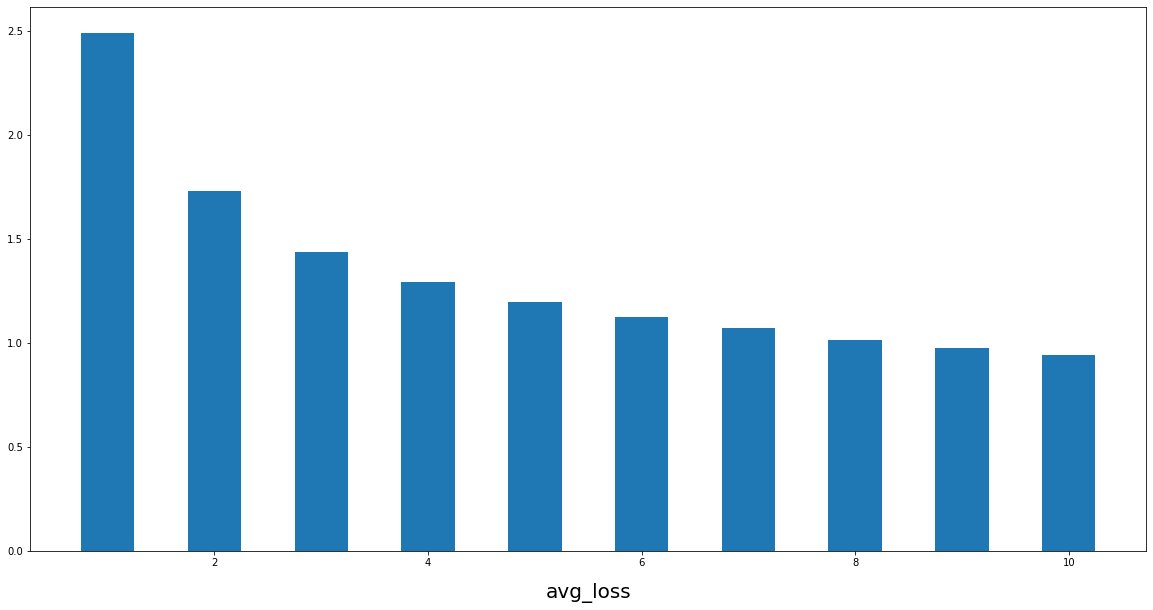

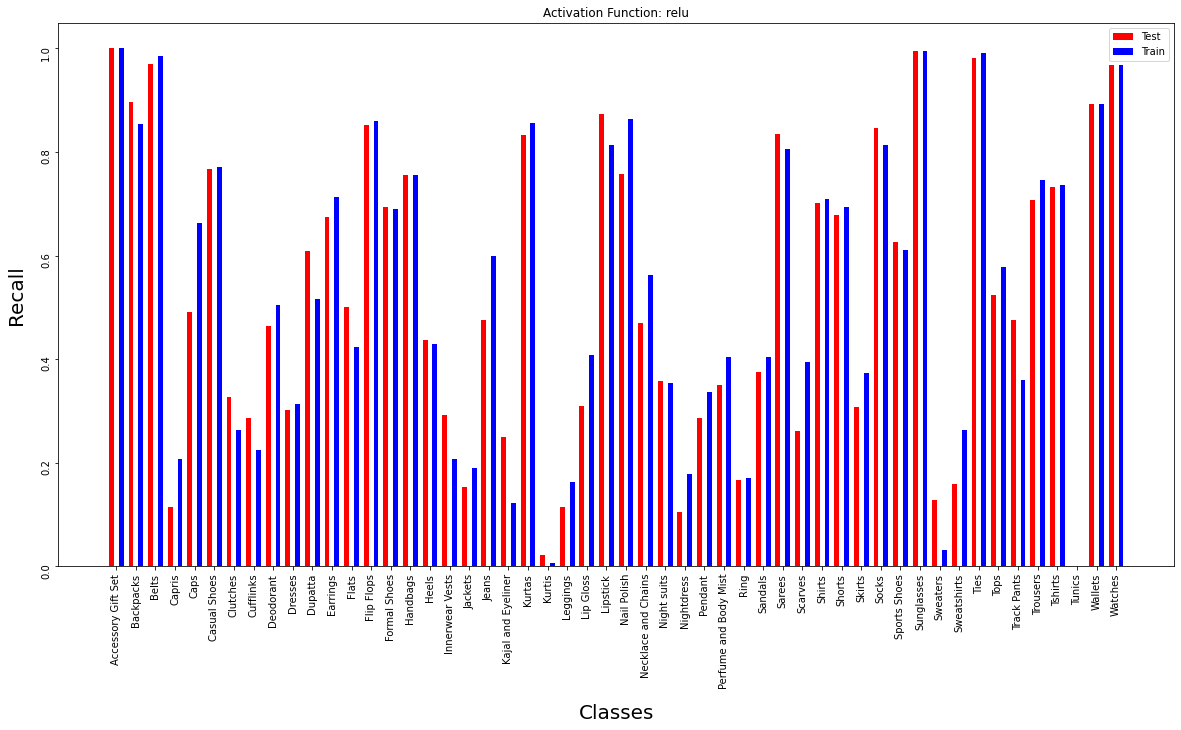

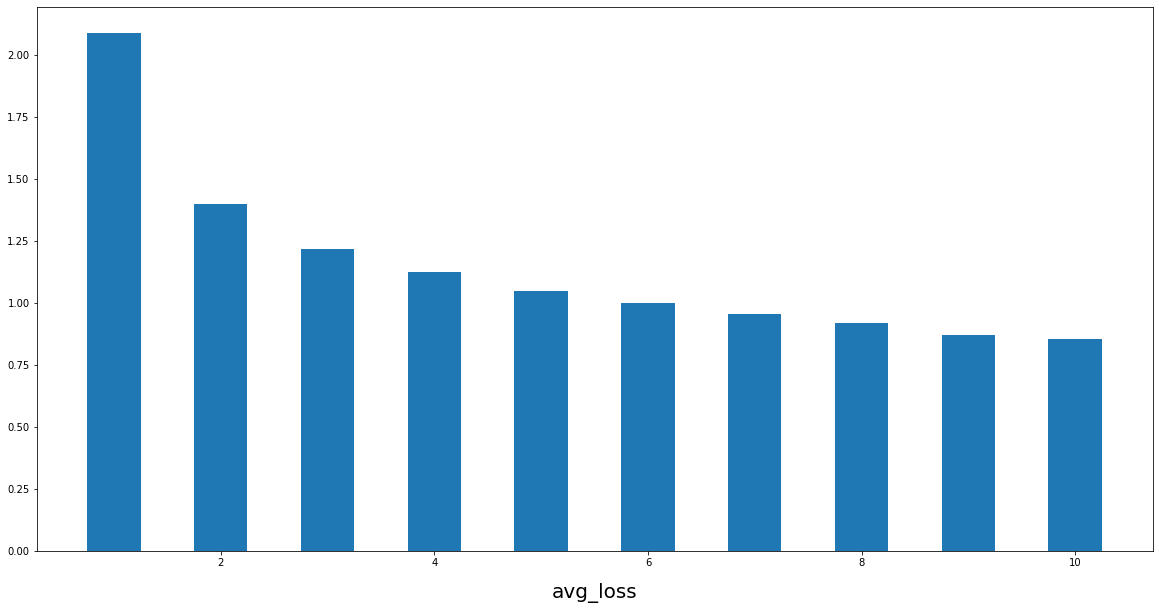

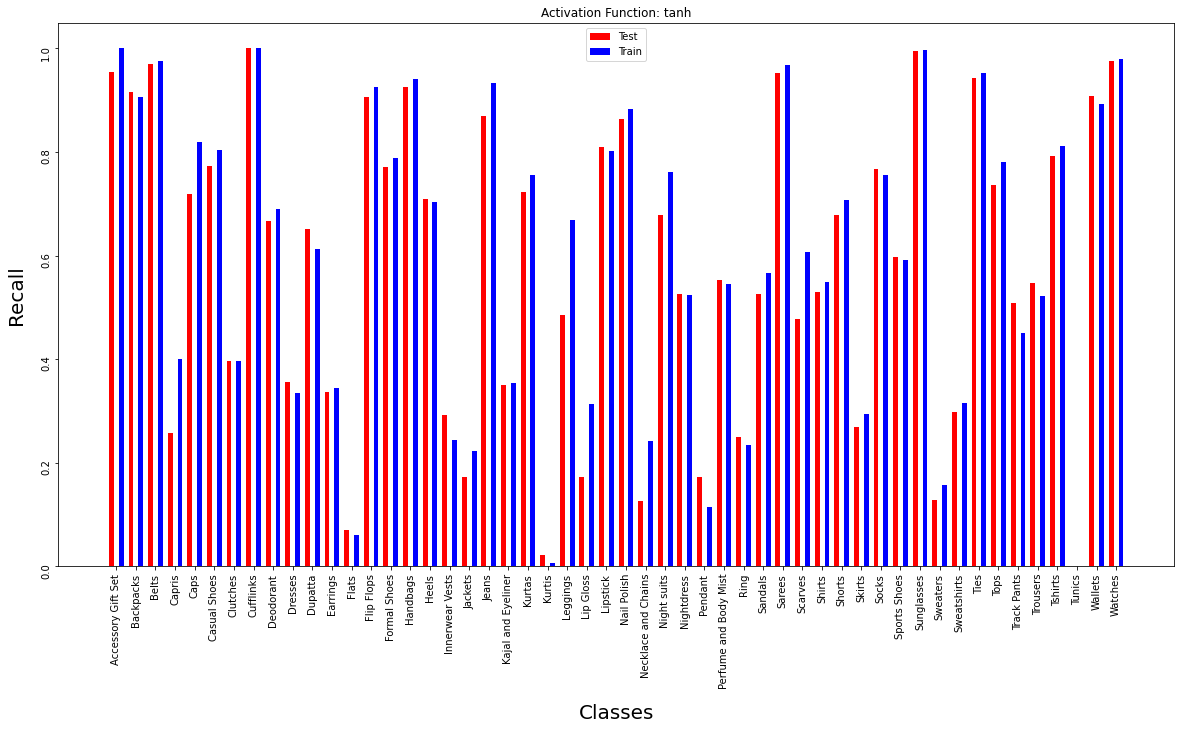

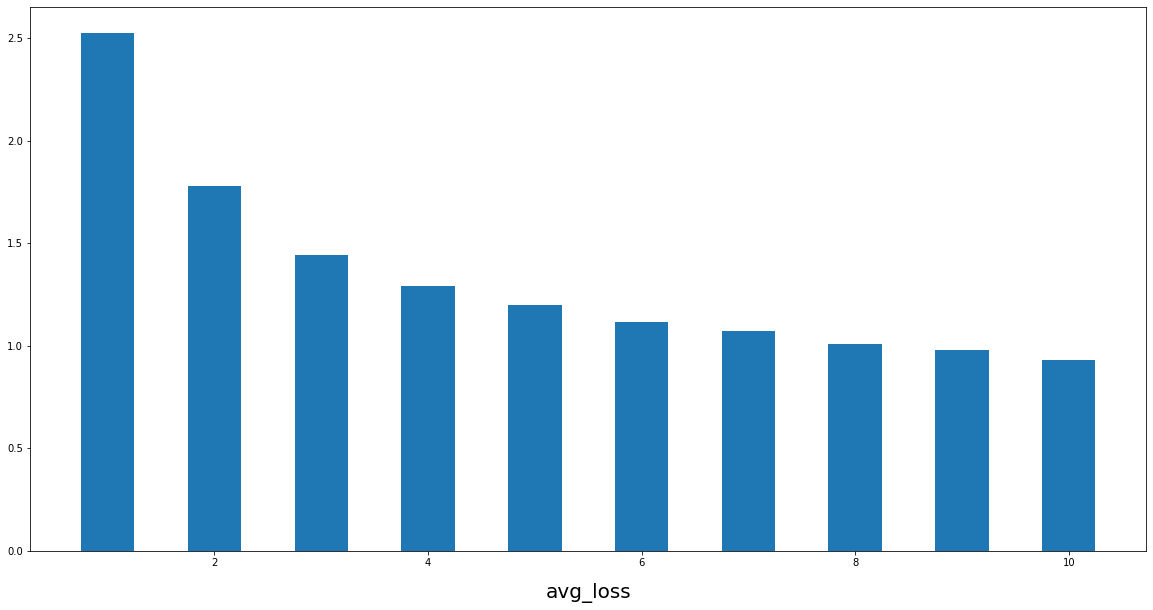

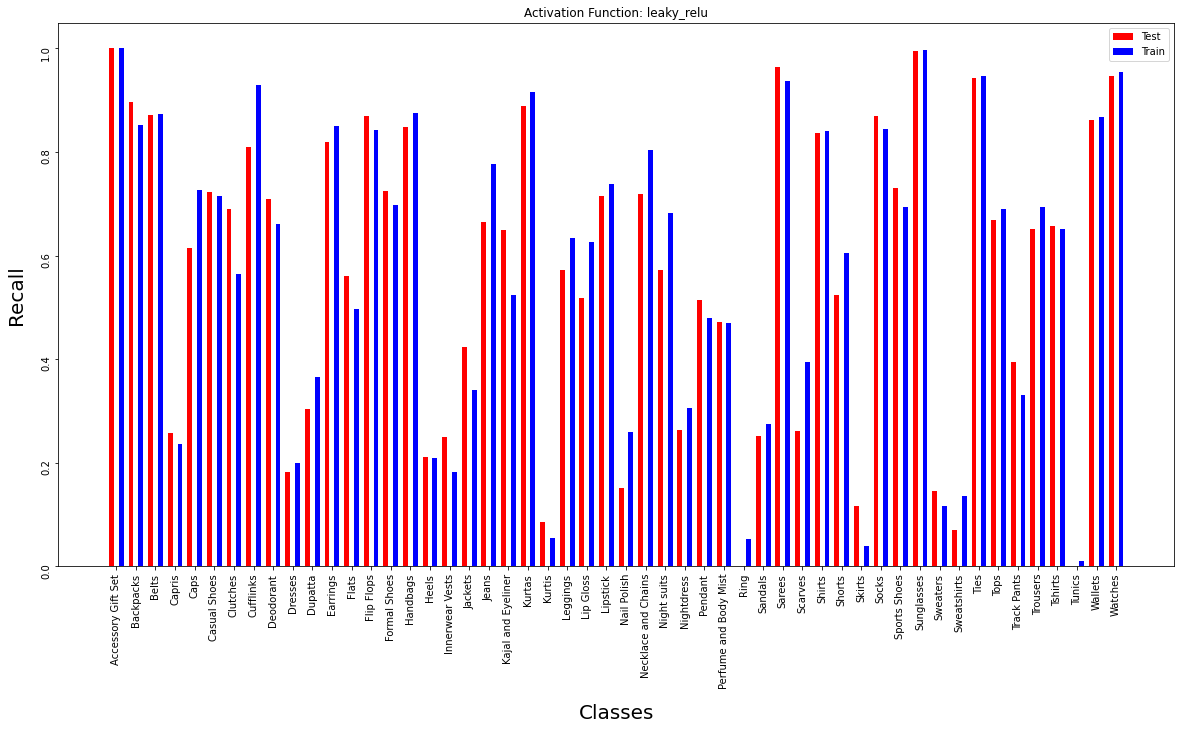

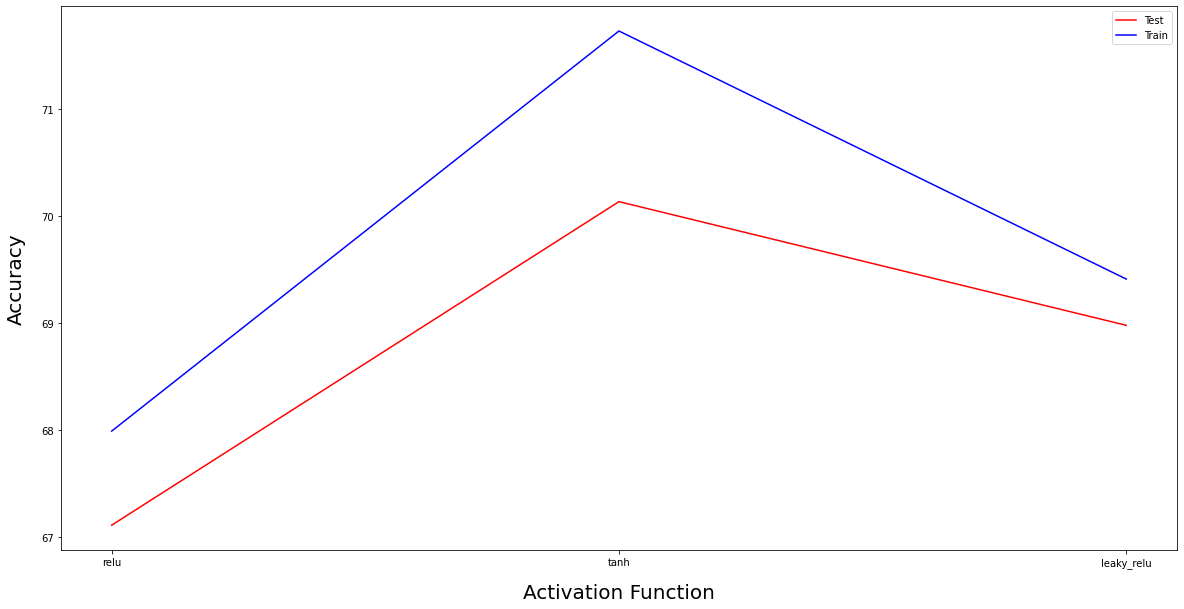

In [ ]:
def get_part_10_results(dataset, layer_inputs, criterion, learning_rate, momentum, train_loader, test_loader):


    test_results = []
    train_results = []
    activation_functions = [
        F.relu,
        F.tanh,
        F.leaky_relu
    ]

    for activation_function in activation_functions:
        print(f'Training network with activation function: {activation_function.__name__}')
        optimized_network = VariableLayerModel(dataset.classes, layer_inputs, act=activation_function)
        optimized_network = optimized_network.to(device)
        optimizer = torch.optim.SGD(optimized_network.parameters(), lr=learning_rate, momentum=momentum)
        fit(optimized_network, train_loader, device, criterion, optimizer)
        test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network, test_loader, dataset.classes)
        train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network, train_loader, dataset.classes)
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
        plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes, title=f'Activation Function: {activation_function.__name__}')
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot([func.__name__ for func in activation_functions], test_results, color='r')
    ax.plot([func.__name__ for func in activation_functions], train_results, color='b')
    ax.set_xlabel("Activation Function",labelpad=15, size=20)
    ax.set_ylabel("Accuracy",labelpad=15, size=20)
    plt.legend(["Test", "Train"])

get_part_10_results(normalized_dataset, optimized_layer_inputs, DEFAULT_LOSS_FUNCTION, optimized_learning_rate, optimized_momentum, normalized_train_loader, normalized_test_loader)

Different activation functions were used and the results can be seen above.
#### ReLU function

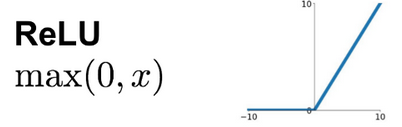

The ReLU function operates in the $[0,\inf)$ range. If the input ($x$) is a negative number, the result will be zero, otherwise $x$ itself will be yielded. It has some pros, such as being computationally cheap as it has no complicated math, it converges fast and does not have the vanishing gradient problem (which some of the other activation functions such as tanh have.) However, there are some downsides too. One of the main problems with this function is called "dying ReLU". As this function results in zero for every negative input, if a neuron gets a negative value once, it's unlikely it will be able to recover afterwards.

#### Leaky ReLU function

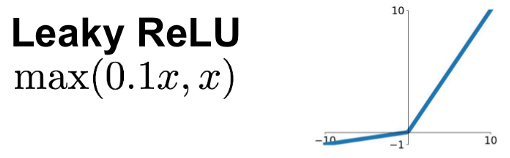

The Leaky ReLU function is a variant of the original ReLU function which tends to solve the "dying ReLU" problem by giving a small slope to the negative side of the results instead of yielding 0. As seen in the plot above, the results with the leaky ReLU as the activation function are slightly better than the results when using ReLU.

#### tanh function

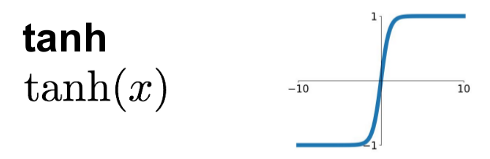

The tanh function isn't linear, it acts in the range of $(-1, 1)$. This function analyzes the negative values better so it has an edge over ReLU and it's variants, but a downside of this function is the vanishing gradient problem, which was explained earlier. In this case, the tanh activation function has resulted in slightly better accuracy than both ReLU and Leaky ReLU. However, as we don't have any negative numbers in the dataset, and the numbers are normalized and in the range of $[0,1]$, the differences between the activation functions are not very considerable.

## Part 11.
Analyzing the effect of regularization.

### Part 11.1

When our models get complicated and use too many features, they overfit to the training dataset, which means they have great accuracy predicting the already-observed training dataset, but face problems processing new data. When a model is overfitted, it seems as if it has memorized the training dataset, instead of learning from it.
However, sometimes the features can't be dropped to make the model simpler, as they are informative and dropping them may cause the model's accuracy to drop. In such cases, regularization is used to prevent overfitting. In regularization, we usually restrict the parameters from getting too large using different techniques, as larger parameters mean more chance of overfitting.

### Part 11.2

Weight decay method works by subtracting a constant (the value of which is less than 1.) times the weight from the original weight. So that it's value can't grow too large and cause overfitting.

### Part 11.3

Training network with weight decay: 0.01
epoch 1, train_loss: 2.568, time elapsed: 20.035276 seconds
epoch 2, train_loss: 2.069, time elapsed: 20.149766 seconds
epoch 3, train_loss: 1.839, time elapsed: 19.963389 seconds
epoch 4, train_loss: 1.763, time elapsed: 20.120155 seconds
epoch 5, train_loss: 1.670, time elapsed: 20.012357 seconds
epoch 6, train_loss: 1.670, time elapsed: 20.098133 seconds
epoch 7, train_loss: 1.619, time elapsed: 19.942452 seconds
epoch 8, train_loss: 1.640, time elapsed: 19.98123 seconds
epoch 9, train_loss: 1.660, time elapsed: 19.959404 seconds
epoch 10, train_loss: 1.699, time elapsed: 20.015982 seconds
total training time: 3.338 minutes
Accuracy: 40.604026845637584%
Accuracy: 40.49464747139166%
Training network with weight decay: 0.1
epoch 1, train_loss: 3.108, time elapsed: 19.750491 seconds
epoch 2, train_loss: 2.980, time elapsed: 19.90745 seconds
epoch 3, train_loss: 3.135, time elapsed: 19.933519 seconds
epoch 4, train_loss: 3.342, time elapsed: 20.0

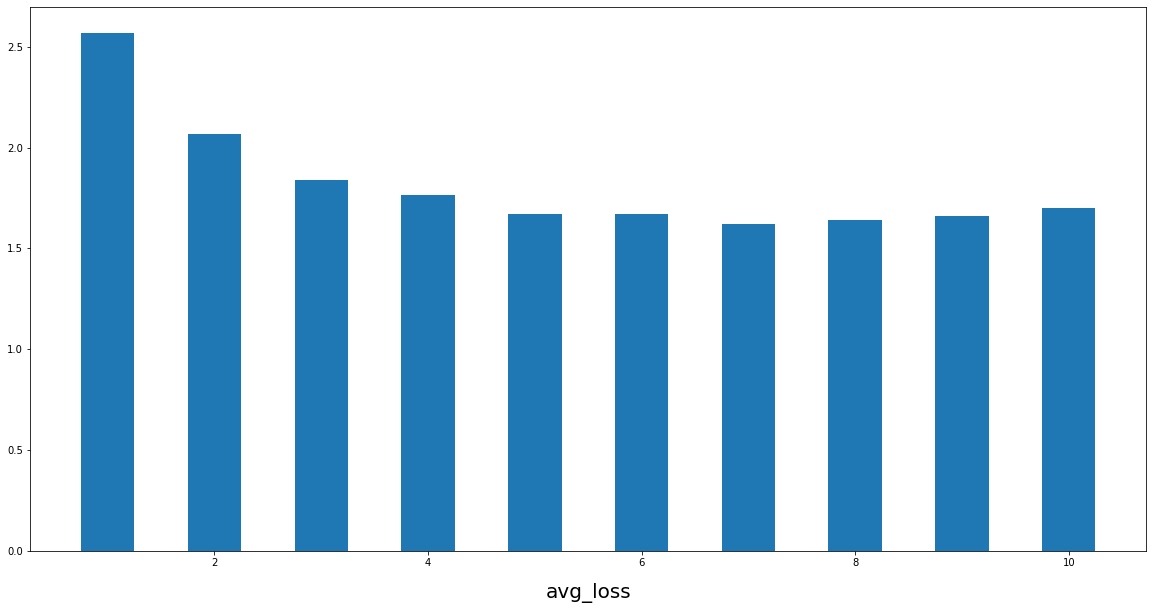

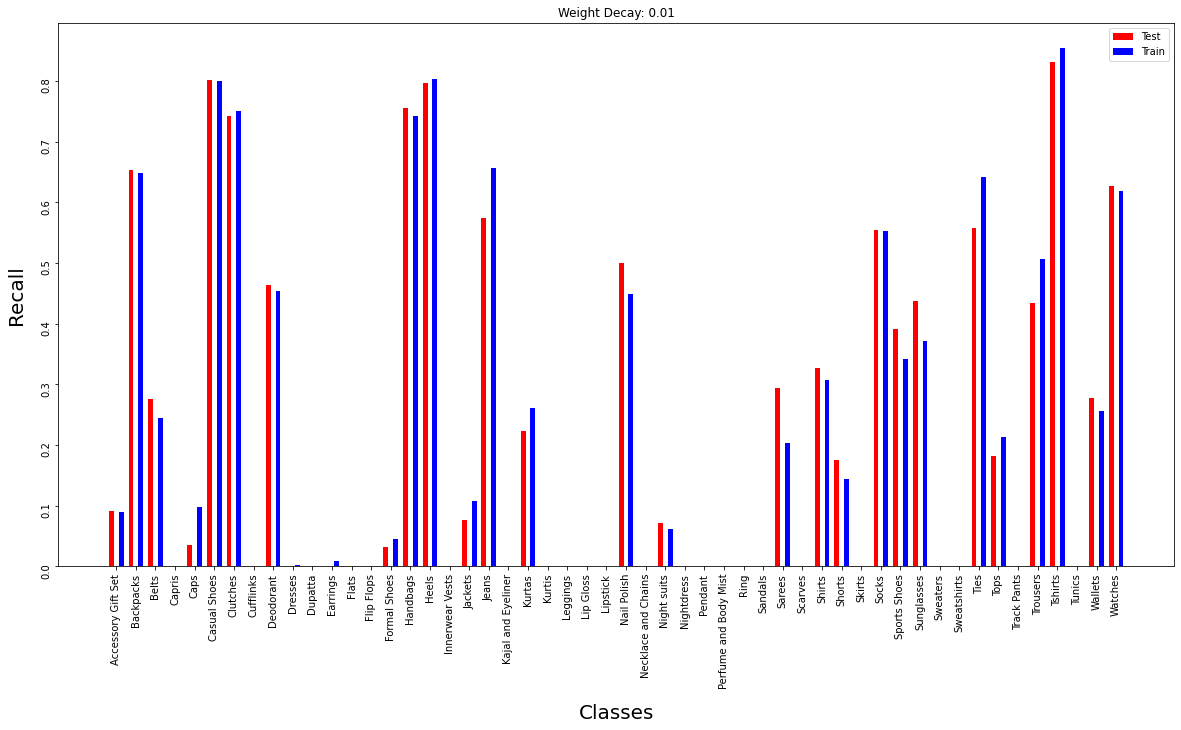

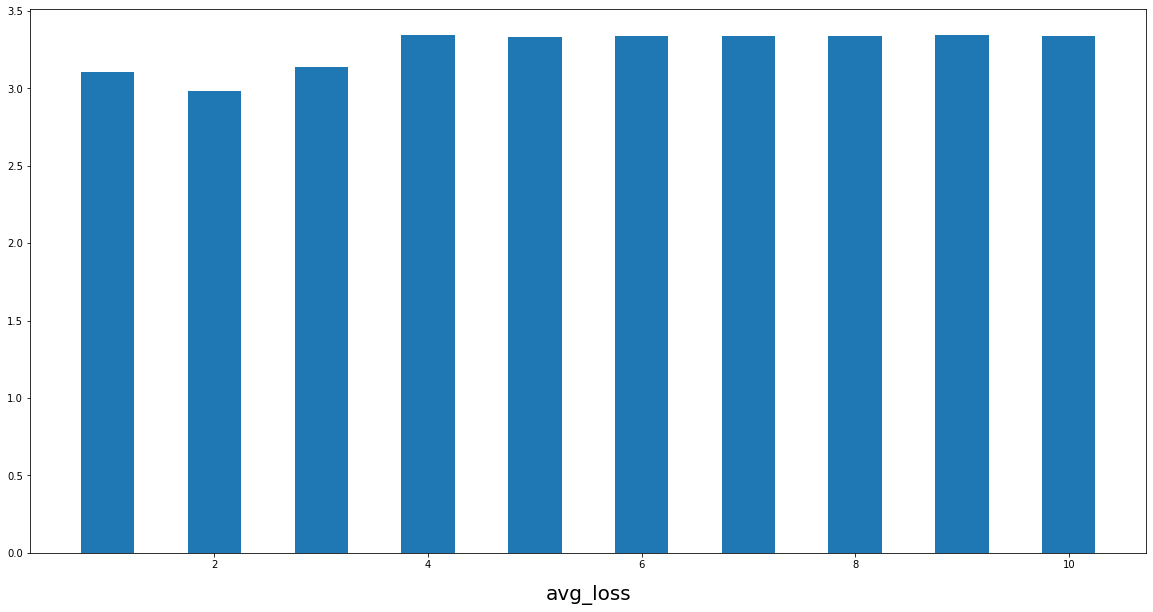

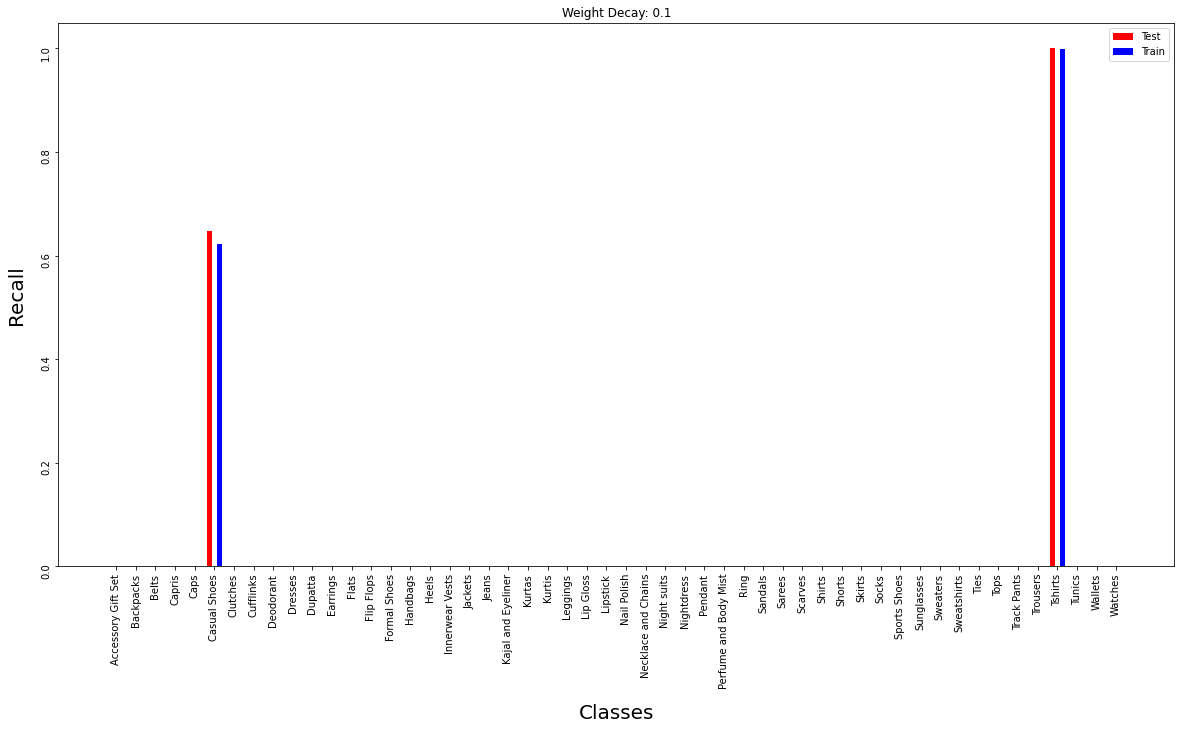

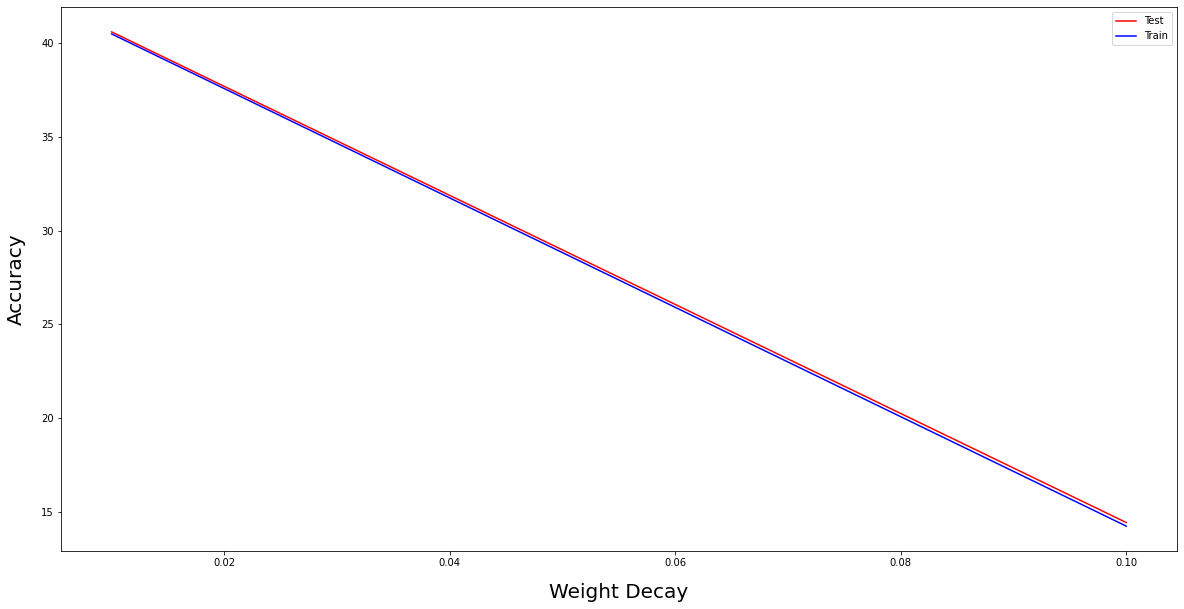

In [ ]:
def get_part_11_results(dataset, layer_inputs, criterion, learning_rate, momentum, train_loader, test_loader):


    test_results = []
    train_results = []
    weight_decay_values = [
        0.01,
        0.1
    ]

    for weight_decay in weight_decay_values:
        print(f'Training network with weight decay: {weight_decay}')
        optimized_network = VariableLayerModel(dataset.classes, layer_inputs)
        optimized_network = optimized_network.to(device)
        optimizer = torch.optim.SGD(optimized_network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        fit(optimized_network, train_loader, device, criterion, optimizer)
        test_total_count , test_correct_predictions, test_accuracy = test_model_accuracy(optimized_network, test_loader, dataset.classes)
        train_total_count , train_correct_predictions, train_accuracy = test_model_accuracy(optimized_network, train_loader, dataset.classes)
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
        plot_class_recalls(test_total_count, test_correct_predictions, train_total_count, train_correct_predictions, dataset.classes, title=f'Weight Decay: {weight_decay}')
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(weight_decay_values, test_results, color='r')
    ax.plot(weight_decay_values, train_results, color='b')
    ax.set_xlabel("Weight Decay",labelpad=15, size=20)
    ax.set_ylabel("Accuracy",labelpad=15, size=20)
    plt.legend(["Test", "Train"])

get_part_11_results(normalized_dataset, optimized_layer_inputs, DEFAULT_LOSS_FUNCTION, optimized_learning_rate, optimized_momentum, normalized_train_loader, normalized_test_loader)

In this assignment, our model hasn't been overfitted to the training set (as the accuracy and recall over the training and test data are similar) so weight decay isn't necessary, and even causes the accuracy of the model to drop. However, the weight decay value of 0.01 affects the training progress less than the 0.1 value, so it has higher accuracy.